## Using an OLS regression model for red wine rankings

For this homework, I will be running a regression based on different attributes of 1600 different red wines. I will begin by importing the dataset:

In [1]:
import pandas as pd

data = pd.read_csv("Red.csv", delimiter = ";", index_col = None)

data

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               7.4             0.700         0.00             1.9      0.076   
1               7.8             0.880         0.00             2.6      0.098   
2               7.8             0.760         0.04             2.3      0.092   
3              11.2             0.280         0.56             1.9      0.075   
4               7.4             0.700         0.00             1.9      0.076   
...             ...               ...          ...             ...        ...   
1594            6.2             0.600         0.08             2.0      0.090   
1595            5.9             0.550         0.10             2.2      0.062   
1596            6.3             0.510         0.13             2.3      0.076   
1597            5.9             0.645         0.12             2.0      0.075   
1598            6.0             0.310         0.47             3.6      0.067   

      free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                    11.0                  34.0  0.99780  3.51       0.56   
1                    25.0                  67.0  0.99680  3.20       0.68   
2                    15.0                  54.0  0.99700  3.26       0.65   
3                    17.0                  60.0  0.99800  3.16       0.58   
4                    11.0                  34.0  0.99780  3.51       0.56   
...                   ...                   ...      ...   ...        ...   
1594                 32.0                  44.0  0.99490  3.45       0.58   
1595                 39.0                  51.0  0.99512  3.52       0.76   
1596                 29.0                  40.0  0.99574  3.42       0.75   
1597                 32.0                  44.0  0.99547  3.57       0.71   
1598                 18.0                  42.0  0.99549  3.39       0.66   

      alcohol  quality  
0         9.4        5  
1         9.8        5  
2         9.8        5  
3         9.8        6  
4         9.4        5  
...       ...      ...  
1594     10.5        5  
1595     11.2        6  
1596     11.0        6  
1597     10.2        5  
1598     11.0        6  

[1599 rows x 12 columns]

Now, I will add my regression class in order to run it. 

In [2]:
from regression import Regression
reg = Regression()
print(reg)

You created an instance of stats()


In [3]:
#regression.py
import pandas as pd
import copy
from stats import *
import numpy as np
from scipy.stats import t, f

class Regression:
    def __init__(self):
        self.stats = stats()
    
    # if constant is True, add a column of ones to 
    # estimate a constant
    def OLS(self, reg_name, data, y_name, beta_names,
            min_val = 0, max_val = None,
            constant = True):
    
        self.min_val = min_val
        if max_val != None:
            self.max_val = max_val
        else:
            self.max_val = len(data)
        self.reg_name = reg_name
        self.y_name = y_name
        
        self.beta_names = copy.copy(beta_names)
        self.data = data.copy()
        if constant:
            self.add_constant()
        self.build_matrices()
        self.estimate_betas_and_yhat()
        self.calculate_regression_stats()
        
    def add_constant(self):
        self.data["Constant"] = 1
        self.beta_names.append("Constant")
        
    def estimate_betas_and_yhat(self):
        # betas = (X'X)**-1 * X'y
        self.betas = np.matmul(self.X_transp_X_inverse, self.X_transp_y)
        # y-hat = X * betas
        self.y_hat = np.matmul(self.X, self.betas)
        self.data[self.y_name[0] + " estimator"] =\
            [i.item(0) for i in self.y_hat]
        # create a table for the estimates
        self.estimates = pd.DataFrame(self.betas, index = self.beta_names,
                                      columns = ["Coefficient"])
        # identify y vairiable in index
        self.estimates.index.name = "y = " + self.y_name[0]
            
            
    def build_matrices(self):
        # Transform dataframes to matrices
        self.y = np.matrix(self.data[self.y_name][self.min_val:self.max_val])
        # create a k X n nested lest containing vectors from each exog var
        self.X = np.matrix(self.data[self.beta_names])
        self.X_transpose = np.matrix(self.X).getT()
        # (X'X)**-1
        X_transp_X = np.matmul(self.X_transpose, self.X)
        self.X_transp_X_inverse = X_transp_X.getI()
        # X'y
        self.X_transp_y = np.matmul(self.X_transpose, self.y)
        

    def calculate_regression_stats(self):
        self.sum_square_stats()
        self.calculate_degrees_of_freedom()
        self.calculate_estimator_variance()
        self.calculate_covariance_matrix()
        self.calculate_t_p_error_stats()
        self.calculate_root_MSE()
        self.calculate_rsquared()
        self.calculate_fstat()
        self.build_stats_DF()
        
    def sum_square_stats(self):
        ssr_list = []
        sse_list = []
        sst_list = []
        mean_y = self.stats.mean(self.y).item(0)
        for i in range(len(self.y)):
            # ssr is sum of squared distances between the estimates
            # and the avergage of y values
            y_hat_i = self.y_hat[i]
            y_i = self.y[i]
            r = y_hat_i - mean_y
            e = y_i - y_hat_i
            t = y_i - mean_y
            ssr_list.append((r) ** 2)
            sse_list.append((e) ** 2)
            sst_list.append((t) ** 2)
        
        # since the ssr, sse, and sst use values from 
        # matrices, select the value within the resultant
        # matrix using matrix.item(0)
        self.ssr = self.stats.total(ssr_list).item(0)
        self.sse = self.stats.total(sse_list).item(0)
        self.sst = self.stats.total(sst_list).item(0)
    
    def calculate_degrees_of_freedom(self):
        # Degrees of freedom compares the number of observations to the number  
        # of exogenous variables used to form the prediction          
        self.lost_degrees_of_freedom = len(self.estimates)
        self.num_obs = self.max_val + 1 - self.min_val
        self.degrees_of_freedom = self.num_obs - self.lost_degrees_of_freedom

    def calculate_estimator_variance(self):
        # estimator variance is the sse normalized by the degrees of freedom  
        # thus, estimator variance increases as the number of exogenous  
        # variables used in estimation increases(i.e., as degrees of freedom   
        # fall) 
        self.estimator_variance = self.sse / self.degrees_of_freedom
    
    def calculate_covariance_matrix(self):
        # Covariance matrix will be used to estimate standard errors for  
        # each coefficient.  
        # estimator variance * (X'X)**-1  
        self.cov_matrix = float(self.estimator_variance) * self.X_transp_X_inverse
        self.cov_matrix = pd.DataFrame(self.cov_matrix,
                                  columns = self.beta_names,
                                  index = self.beta_names)
        
    def calculate_t_p_error_stats(self):
        results = self.estimates
        stat_sig_names = ["SE", "t-stat", "p-value"]
        # create space in data frame for SE, t, and p
        for stat_name in stat_sig_names:
            results[stat_name] = np.nan
        # generate statistic for each variable
        for var in self.beta_names:
            # SE ** 2 of coefficient is found in the diagonal of the cov_matrix
            results.loc[var]["SE"] = self.cov_matrix[var][var] ** (1/2)     
            # t-stat = Coef / SE
            results.loc[var]["t-stat"] = \
                results["Coefficient"][var] / results["SE"][var]
            # p-values is estimated using a table that transforms t-stat in   
            # light of degrees of freedom  
            # 2 is for 2 tail...
            # 5 is to round to 5 decimal places
            results.loc[var]["p-value"] = np.round(
                t.sf(np.abs(results.loc[var]["t-stat"]), 
                     self.degrees_of_freedom +1) * 2, 5)
        ratings = [.05, .01, .001]
        significance = ["" for name in self.beta_names]
        for i in range(len(self.beta_names)):
            var = self.beta_names[i]
            for rating in ratings:
                if results.loc[var]["p-value"] < rating:
                    significance[i] = significance[i] + "*"
        results["significance"] = significance

    def calculate_root_MSE(self):
        self.root_mse = self.estimator_variance ** (1/2)
    
    def calculate_rsquared(self):
        self.r_sq = self.ssr / self.sst
    
    def calculate_fstat(self):
        self.f_stat = (self.sst - self.sse) / (self.lost_degrees_of_freedom\
                                               - 1) / self.estimator_variance
    
    def build_stats_DF(self):
        stats_dict = {"r**2": [self.r_sq],
                      "f-stat":[self.f_stat],
                      "Est Var":[self.estimator_variance],
                      "rootMSE":[self.root_mse],
                      "SSE":[self.sse],
                      "SSR": [self.ssr],
                      "SST":[self.sst],
                      "Obs.":[int(self.num_obs)],
                      "DOF":[int(self.degrees_of_freedom)]}
        self.stats_DF = pd.DataFrame(stats_dict)
        self.stats_DF = self.stats_DF.rename(index = {0:"Estimation Statistics"})
        self.stats_DF = self.stats_DF.T 

Now I will select my variables that I want to test for significance. I am going to use volatile acidity (which causes the bitterness) as my x variable to test for the significance of the others. I will select a few others for my y-values.

In [4]:
y_var = ["volatile acidity"]
# independent variables
x_vars = ["fixed acidity", "citric acid", 
          "residual sugar",
          "chlorides",
         "free sulfur dioxide", "total sulfur dioxide", "density",
         "pH","sulphates","alcohol", "quality"]
reg.OLS(reg_name = "Volatile Acidity", data = data, 
        y_name = y_var, beta_names = x_vars)
reg.data

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               7.4             0.700         0.00             1.9      0.076   
1               7.8             0.880         0.00             2.6      0.098   
2               7.8             0.760         0.04             2.3      0.092   
3              11.2             0.280         0.56             1.9      0.075   
4               7.4             0.700         0.00             1.9      0.076   
...             ...               ...          ...             ...        ...   
1594            6.2             0.600         0.08             2.0      0.090   
1595            5.9             0.550         0.10             2.2      0.062   
1596            6.3             0.510         0.13             2.3      0.076   
1597            5.9             0.645         0.12             2.0      0.075   
1598            6.0             0.310         0.47             3.6      0.067   

      free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                    11.0                  34.0  0.99780  3.51       0.56   
1                    25.0                  67.0  0.99680  3.20       0.68   
2                    15.0                  54.0  0.99700  3.26       0.65   
3                    17.0                  60.0  0.99800  3.16       0.58   
4                    11.0                  34.0  0.99780  3.51       0.56   
...                   ...                   ...      ...   ...        ...   
1594                 32.0                  44.0  0.99490  3.45       0.58   
1595                 39.0                  51.0  0.99512  3.52       0.76   
1596                 29.0                  40.0  0.99574  3.42       0.75   
1597                 32.0                  44.0  0.99547  3.57       0.71   
1598                 18.0                  42.0  0.99549  3.39       0.66   

      alcohol  quality  Constant  volatile acidity estimator  
0         9.4        5         1                    0.719038  
1         9.8        5         1                    0.704225  
2         9.8        5         1                    0.697201  
3         9.8        6         1                    0.382687  
4         9.4        5         1                    0.719038  
...       ...      ...       ...                         ...  
1594     10.5        5         1                    0.587991  
1595     11.2        6         1                    0.494105  
1596     11.0        6         1                    0.511586  
1597     10.2        5         1                    0.534526  
1598     11.0        6         1                    0.323452  

[1599 rows x 14 columns]

In [5]:
reg.estimates

Coefficient        SE     t-stat  p-value significance
y = volatile acidity                                                        
fixed acidity            0.011253  0.005240   2.147450  0.03191            *
citric acid             -0.627595  0.025264 -24.841846  0.00000          ***
residual sugar          -0.002109  0.003034  -0.695221  0.48702             
chlorides                0.787104  0.082984   9.484954  0.00000          ***
free sulfur dioxide     -0.002629  0.000435  -6.049164  0.00000          ***
total sulfur dioxide     0.001082  0.000146   7.422124  0.00000          ***
density                 21.046351  4.342727   4.846345  0.00000          ***
pH                       0.021802  0.038790   0.562051  0.57416             
sulphates               -0.147622  0.023287  -6.339204  0.00000          ***
alcohol                  0.028670  0.005488   5.224154  0.00000          ***
quality                 -0.044322  0.004952  -8.950621  0.00000          ***
Constant               -20.469707  4.255683  -4.809970  0.00000          ***

As we can see, there are a few variables that are significant, and a few that have little to no significance.

In [6]:
reg.ssr, reg.sse, reg.sst

reg.stats_DF

Estimation Statistics
r**2                  0.467990
f-stat              126.991389
Est Var               0.017165
rootMSE               0.131015
SSE                  27.257903
SSR                  23.977776
SST                  51.235679
Obs.               1600.000000
DOF                1588.000000

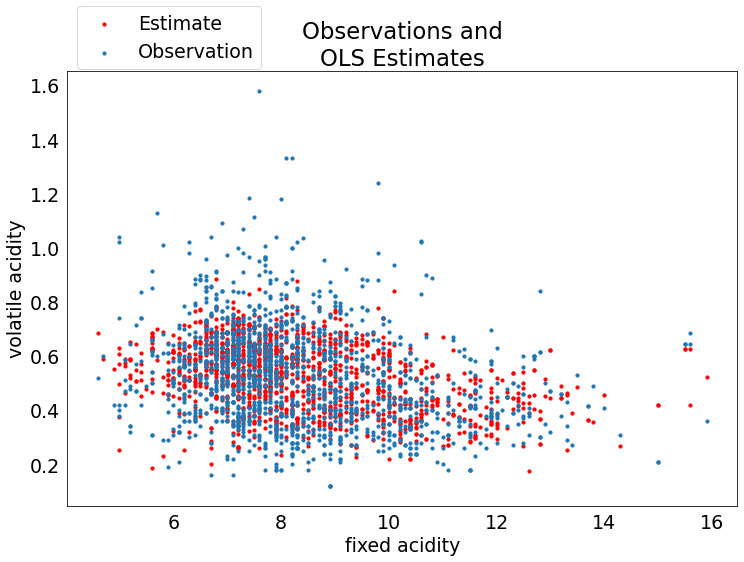

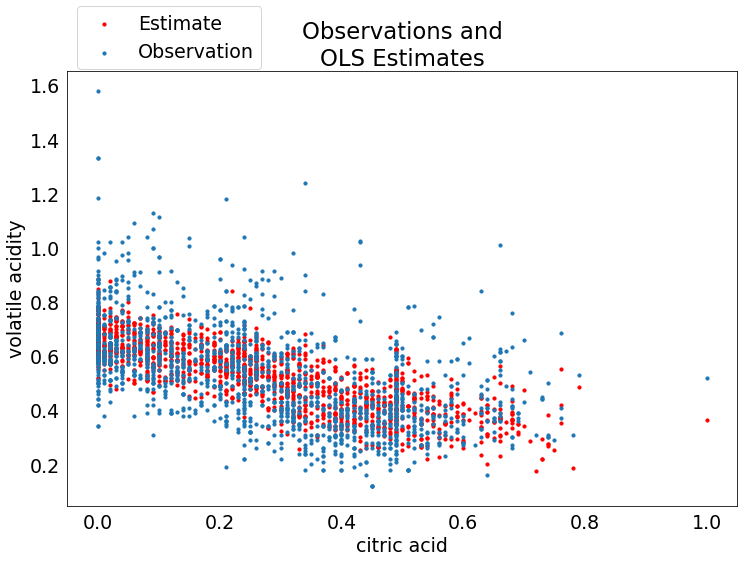

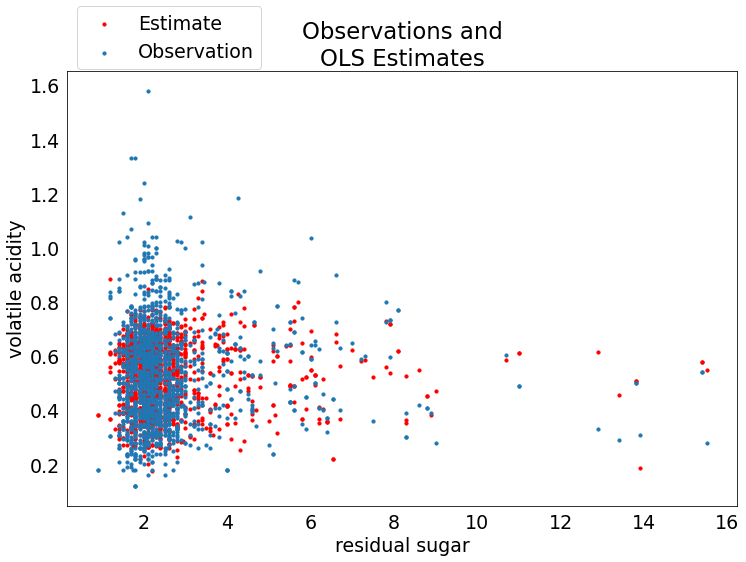

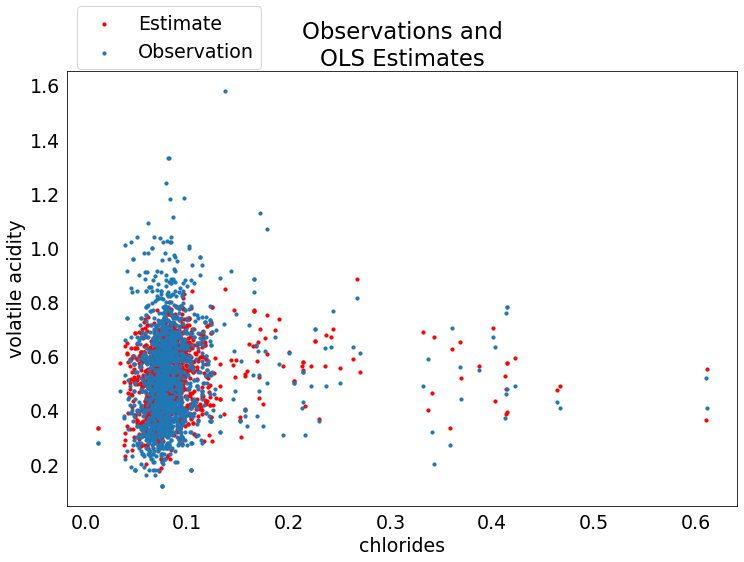

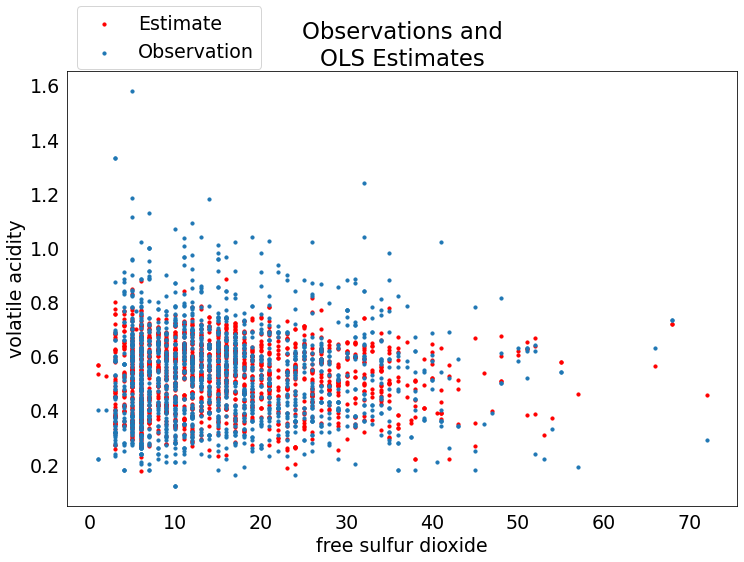

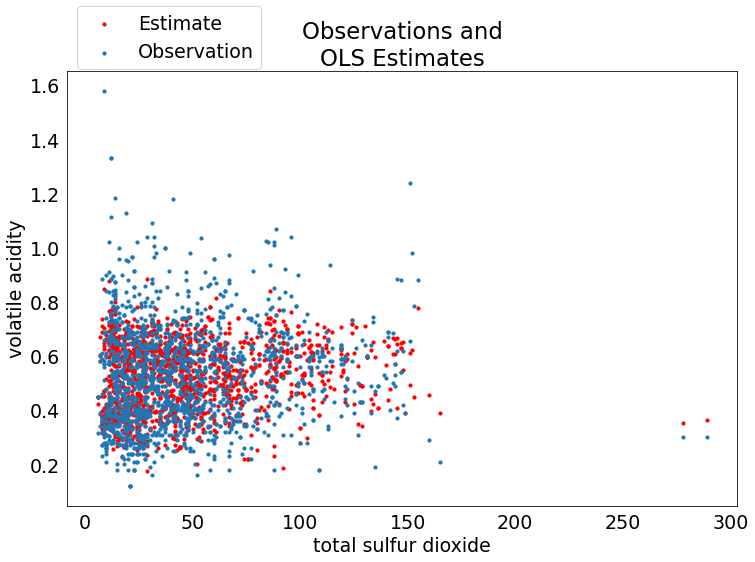

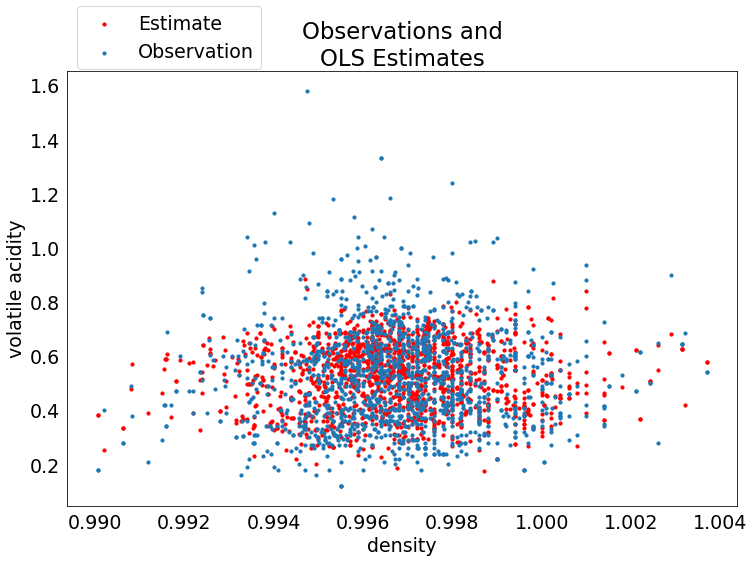

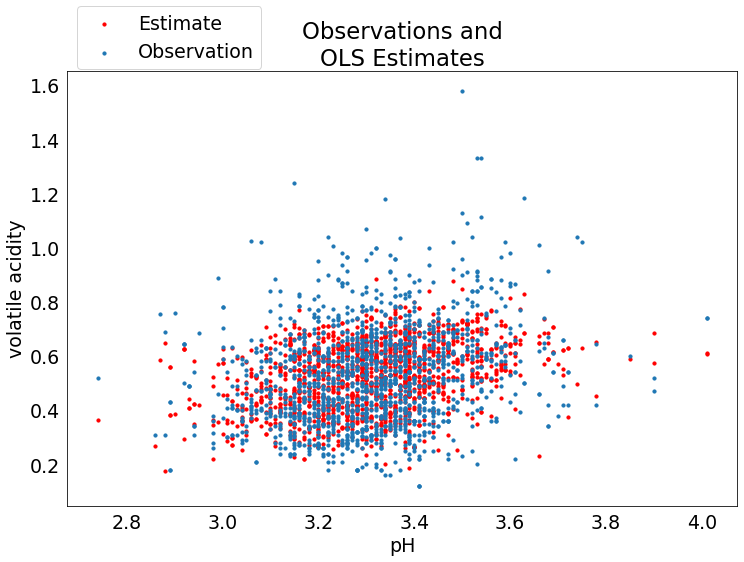

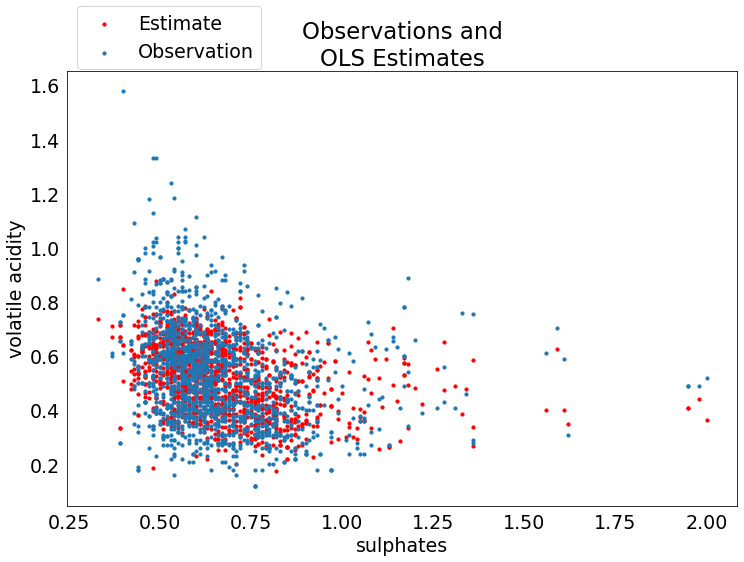

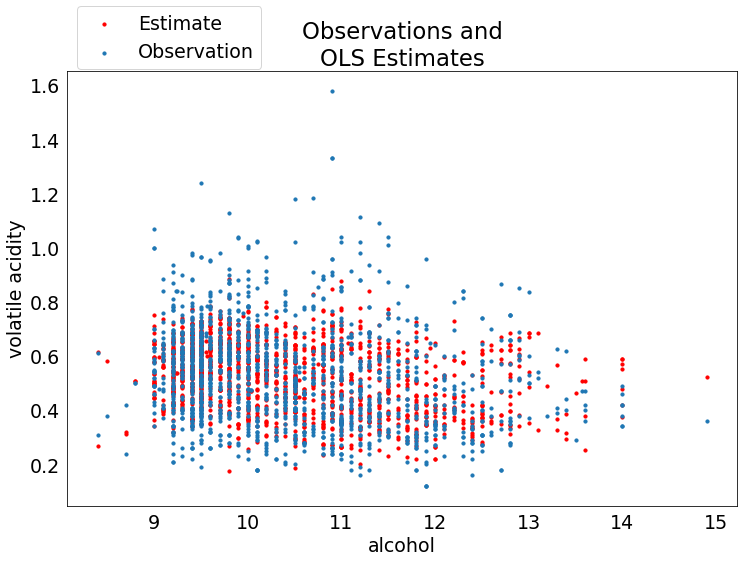

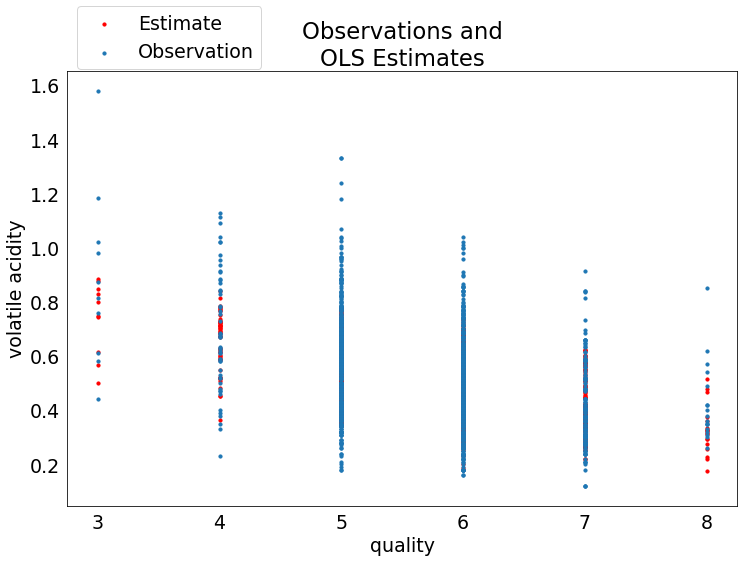

In [7]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

def plot_scatter_with_estimator(title, data, x_vars, y_var, pp = None):
    # set default font size
    plt.rcParams.update({"font.size":19})
    # use a loop to call each exogenous
    y = y_var[0]
    for x in x_vars:
        fig, ax = plt.subplots(figsize=(12,8))
        y_label1 = "Estimate"
        y_label2 = "Observation"
        data.plot.scatter(x=x, y=y + " estimator", ax = ax, c = "r",
                         s = 10, label = y_label1, legend = False)
        
        # erase the y_axis label so that "estimtor" is not present
        plt.ylabel("")
        data.plot.scatter(x = x, y = y, ax = ax, s = 10, 
                          label = y_label2, legend = False)
        plt.legend(loc="upper left", labels = [y_label1, y_label2],
                  bbox_to_anchor = (0, 1.17))
        
        plt.title("Observations and\nOLS Estimates")
        # remove lines marking unit on the axis
        ax.xaxis.set_ticks_position("none")
        ax.yaxis.set_ticks_position("none")
        pp.savefig(fig, bbox_inches = "tight")
pp = PdfPages("WineRegressionPlots.pdf")
plot_scatter_with_estimator("Plot", reg.data, x_vars, y_var, pp)

### plot 

pp.close()

The code above has adressed questions 1&2. I will use the numpy libraries log function now.

In [30]:
import pandas as pd  
import numpy as np    
        
data2 = pd.read_csv("Red.csv", delimiter = ";", index_col = None)  
pd.set_option('use_inf_as_na', True)
np.log(data2)

<ipython-input-30-3f829cd35ce6>:5: RuntimeWarning: divide by zero encountered in log
  new = np.log(data2)


fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0          2.001480         -0.356675          NaN        0.641854  -2.577022   
1          2.054124         -0.127833          NaN        0.955511  -2.322788   
2          2.054124         -0.274437    -3.218876        0.832909  -2.385967   
3          2.415914         -1.272966    -0.579818        0.641854  -2.590267   
4          2.001480         -0.356675          NaN        0.641854  -2.577022   
...             ...               ...          ...             ...        ...   
1594       1.824549         -0.510826    -2.525729        0.693147  -2.407946   
1595       1.774952         -0.597837    -2.302585        0.788457  -2.780621   
1596       1.840550         -0.673345    -2.040221        0.832909  -2.577022   
1597       1.774952         -0.438505    -2.120264        0.693147  -2.590267   
1598       1.791759         -1.171183    -0.755023        1.280934  -2.703063   

      free sulfur dioxide  total sulfur dioxide   density        pH  \
0                2.397895              3.526361 -0.002202  1.255616   
1                3.218876              4.204693 -0.003205  1.163151   
2                2.708050              3.988984 -0.003005  1.181727   
3                2.833213              4.094345 -0.002002  1.150572   
4                2.397895              3.526361 -0.002202  1.255616   
...                   ...                   ...       ...       ...   
1594             3.465736              3.784190 -0.005113  1.238374   
1595             3.663562              3.931826 -0.004892  1.258461   
1596             3.367296              3.688879 -0.004269  1.229641   
1597             3.465736              3.784190 -0.004540  1.272566   
1598             2.890372              3.737670 -0.004520  1.220830   

      sulphates   alcohol   quality  
0     -0.579818  2.240710  1.609438  
1     -0.385662  2.282382  1.609438  
2     -0.430783  2.282382  1.609438  
3     -0.544727  2.282382  1.791759  
4     -0.579818  2.240710  1.609438  
...         ...       ...       ...  
1594  -0.544727  2.351375  1.609438  
1595  -0.274437  2.415914  1.791759  
1596  -0.287682  2.397895  1.791759  
1597  -0.342490  2.322388  1.609438  
1598  -0.415515  2.397895  1.791759  

[1599 rows x 12 columns]

In [43]:
reg2 = Regression()

y_var = ["volatile acidity"]
# independent variables
x_vars = ["fixed acidity", "citric acid", 
         "free sulfur dioxide", "total sulfur dioxide", "density",
         "alcohol", "quality"]
reg2.OLS(reg_name = "Volatile Acidity", data = data2, 
        y_name = y_var, beta_names = x_vars)
reg2.data

You created an instance of stats()


fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               7.4             0.700         0.00             1.9      0.076   
1               7.8             0.880         0.00             2.6      0.098   
2               7.8             0.760         0.04             2.3      0.092   
3              11.2             0.280         0.56             1.9      0.075   
4               7.4             0.700         0.00             1.9      0.076   
...             ...               ...          ...             ...        ...   
1594            6.2             0.600         0.08             2.0      0.090   
1595            5.9             0.550         0.10             2.2      0.062   
1596            6.3             0.510         0.13             2.3      0.076   
1597            5.9             0.645         0.12             2.0      0.075   
1598            6.0             0.310         0.47             3.6      0.067   

      free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                    11.0                  34.0  0.99780  3.51       0.56   
1                    25.0                  67.0  0.99680  3.20       0.68   
2                    15.0                  54.0  0.99700  3.26       0.65   
3                    17.0                  60.0  0.99800  3.16       0.58   
4                    11.0                  34.0  0.99780  3.51       0.56   
...                   ...                   ...      ...   ...        ...   
1594                 32.0                  44.0  0.99490  3.45       0.58   
1595                 39.0                  51.0  0.99512  3.52       0.76   
1596                 29.0                  40.0  0.99574  3.42       0.75   
1597                 32.0                  44.0  0.99547  3.57       0.71   
1598                 18.0                  42.0  0.99549  3.39       0.66   

      alcohol  quality  Constant  volatile acidity estimator  
0         9.4        5         1                    0.719515  
1         9.8        5         1                    0.705282  
2         9.8        5         1                    0.699444  
3         9.8        6         1                    0.378937  
4         9.4        5         1                    0.719515  
...       ...      ...       ...                         ...  
1594     10.5        5         1                    0.580187  
1595     11.2        6         1                    0.517518  
1596     11.0        6         1                    0.527042  
1597     10.2        5         1                    0.558981  
1598     11.0        6         1                    0.346600  

[1599 rows x 14 columns]

In [42]:
reg2.estimates

Coefficient        SE     t-stat  p-value significance
y = volatile acidity                                                        
fixed acidity            0.007888  0.003550   2.222108  0.02642            *
citric acid             -0.601121  0.024761 -24.276567  0.00000          ***
free sulfur dioxide     -0.002671  0.000441  -6.054366  0.00000          ***
total sulfur dioxide     0.000962  0.000146   6.591235  0.00000          ***
density                 20.011166  3.064738   6.529487  0.00000          ***
alcohol                  0.020669  0.004377   4.722610  0.00000          ***
quality                 -0.055187  0.004918 -11.221017  0.00000          ***
Constant               -19.227685  3.061588  -6.280297  0.00000          ***

In [36]:
reg2.stats_DF

Estimation Statistics
r**2                  0.433795
f-stat              174.243335
Est Var               0.018222
rootMSE               0.134990
SSE                  29.009889
SSR                  22.225791
SST                  51.235679
Obs.               1600.000000
DOF                1592.000000

So, I used the same y-value (volatile acidity), and took out the insignificant values to see what would change in the statistical regression. We can see that the correlation went down, and that there are small changes in the volatile acidity estimators across each observation. Also, a few of the estimation statistics had very minimal increases/decreases. Now, I will produce the same graphs and see if there is anything different.

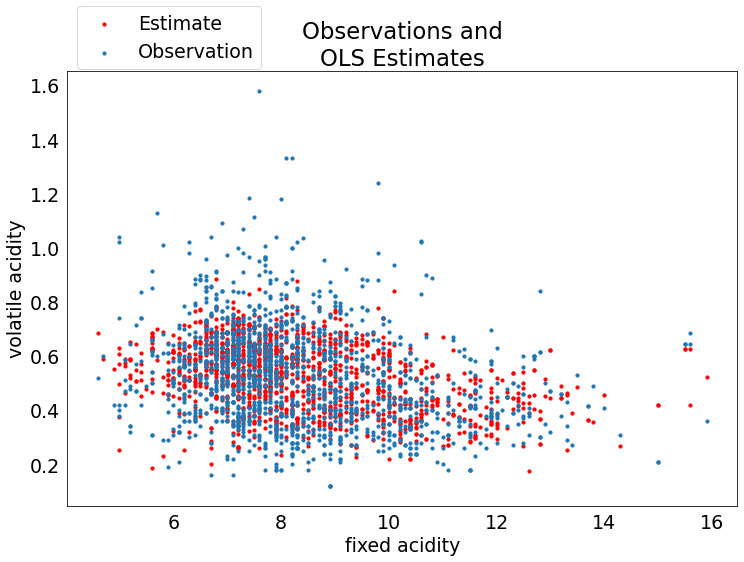

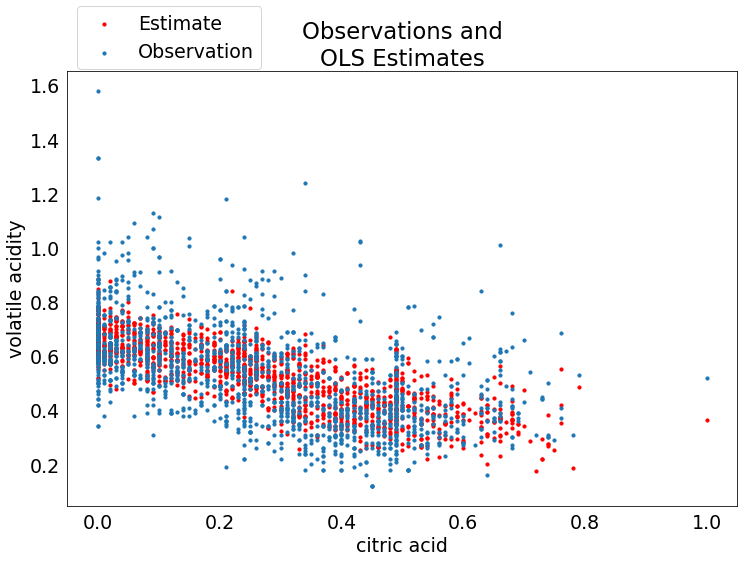

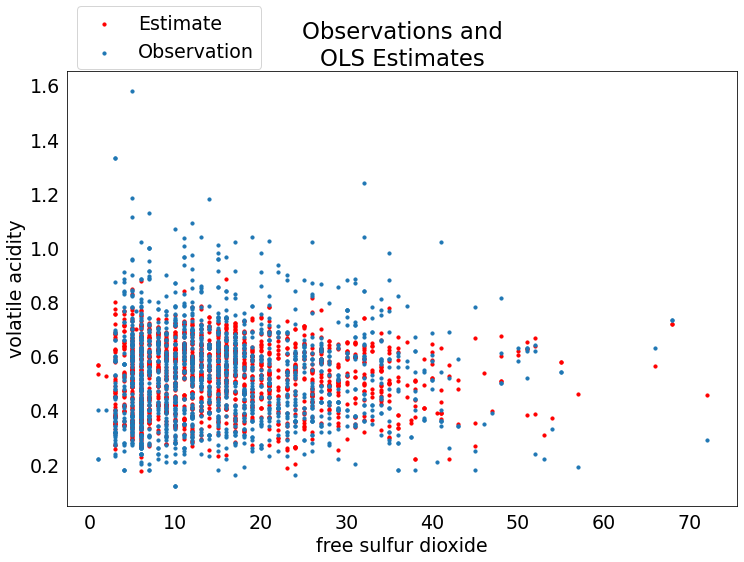

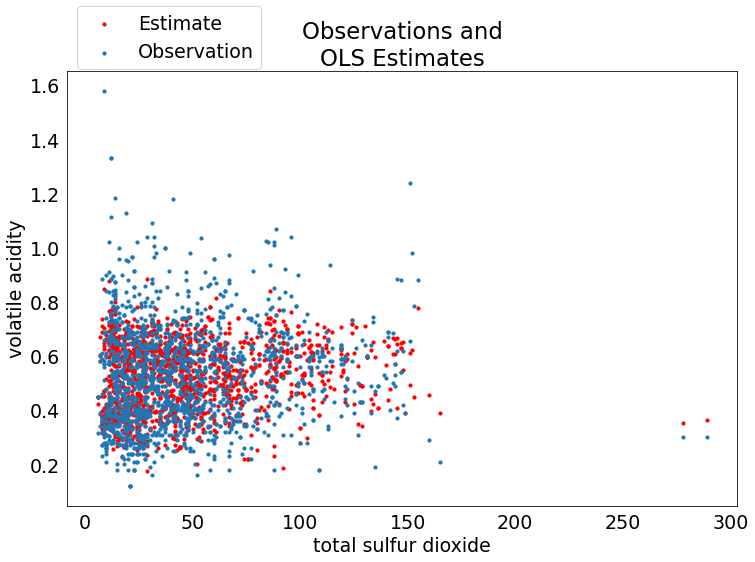

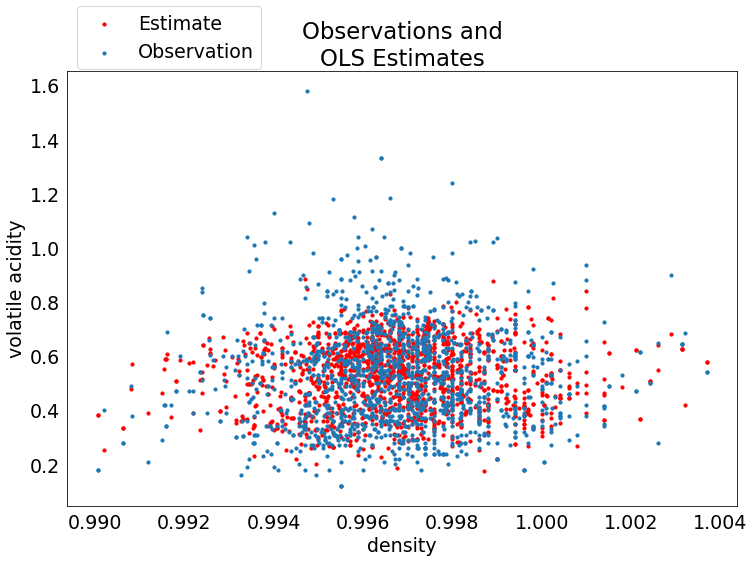

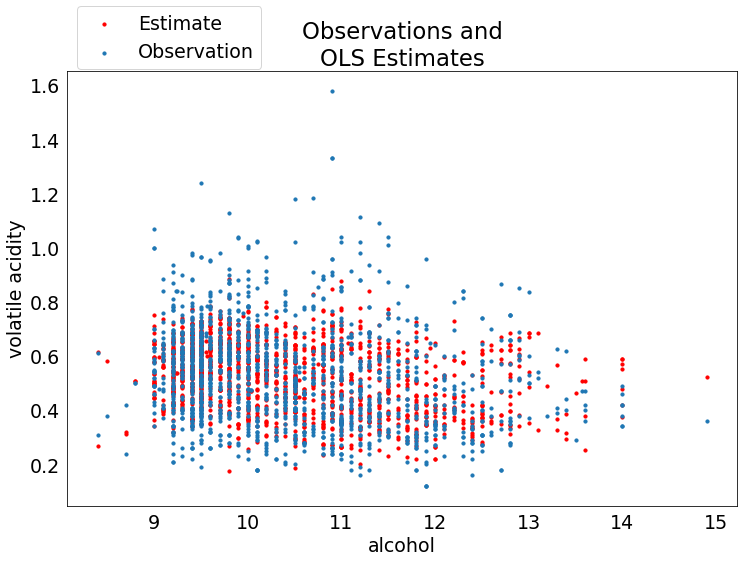

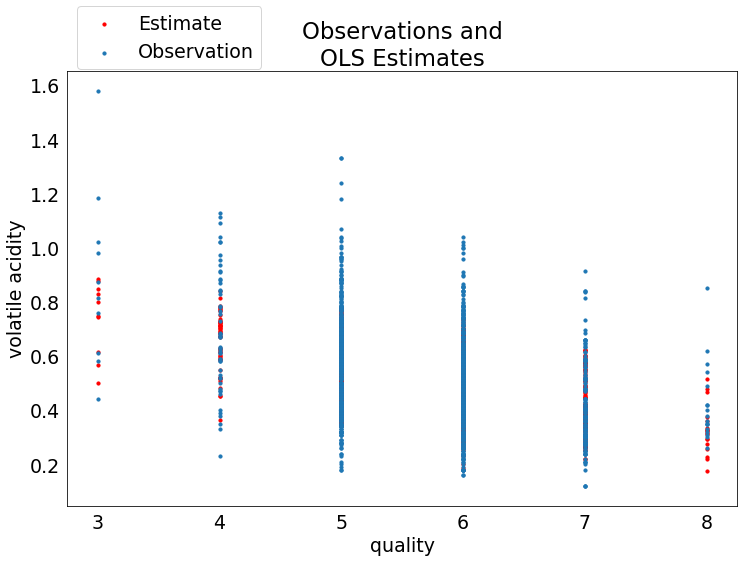

In [37]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

def plot_scatter_with_estimator(title, data2, x_vars, y_var, pp = None):
    # set default font size
    plt.rcParams.update({"font.size":19})
    # use a loop to call each exogenous
    y = y_var[0]
    for x in x_vars:
        fig, ax = plt.subplots(figsize=(12,8))
        y_label1 = "Estimate"
        y_label2 = "Observation"
        data2.plot.scatter(x=x, y=y + " estimator", ax = ax, c = "r",
                         s = 10, label = y_label1, legend = False)
        
        # erase the y_axis label so that "estimtor" is not present
        plt.ylabel("")
        data2.plot.scatter(x = x, y = y, ax = ax, s = 10, 
                          label = y_label2, legend = False)
        plt.legend(loc="upper left", labels = [y_label1, y_label2],
                  bbox_to_anchor = (0, 1.17))
        
        plt.title("Observations and\nOLS Estimates")
        # remove lines marking unit on the axis
        ax.xaxis.set_ticks_position("none")
        ax.yaxis.set_ticks_position("none")
        pp.savefig(fig, bbox_inches = "tight")
pp = PdfPages("WineRegressionPlots2.pdf")
plot_scatter_with_estimator("Plot", reg.data, x_vars, y_var, pp)

### plot 

pp.close()

<ipython-input-63-babda660478d>:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize = figsize)


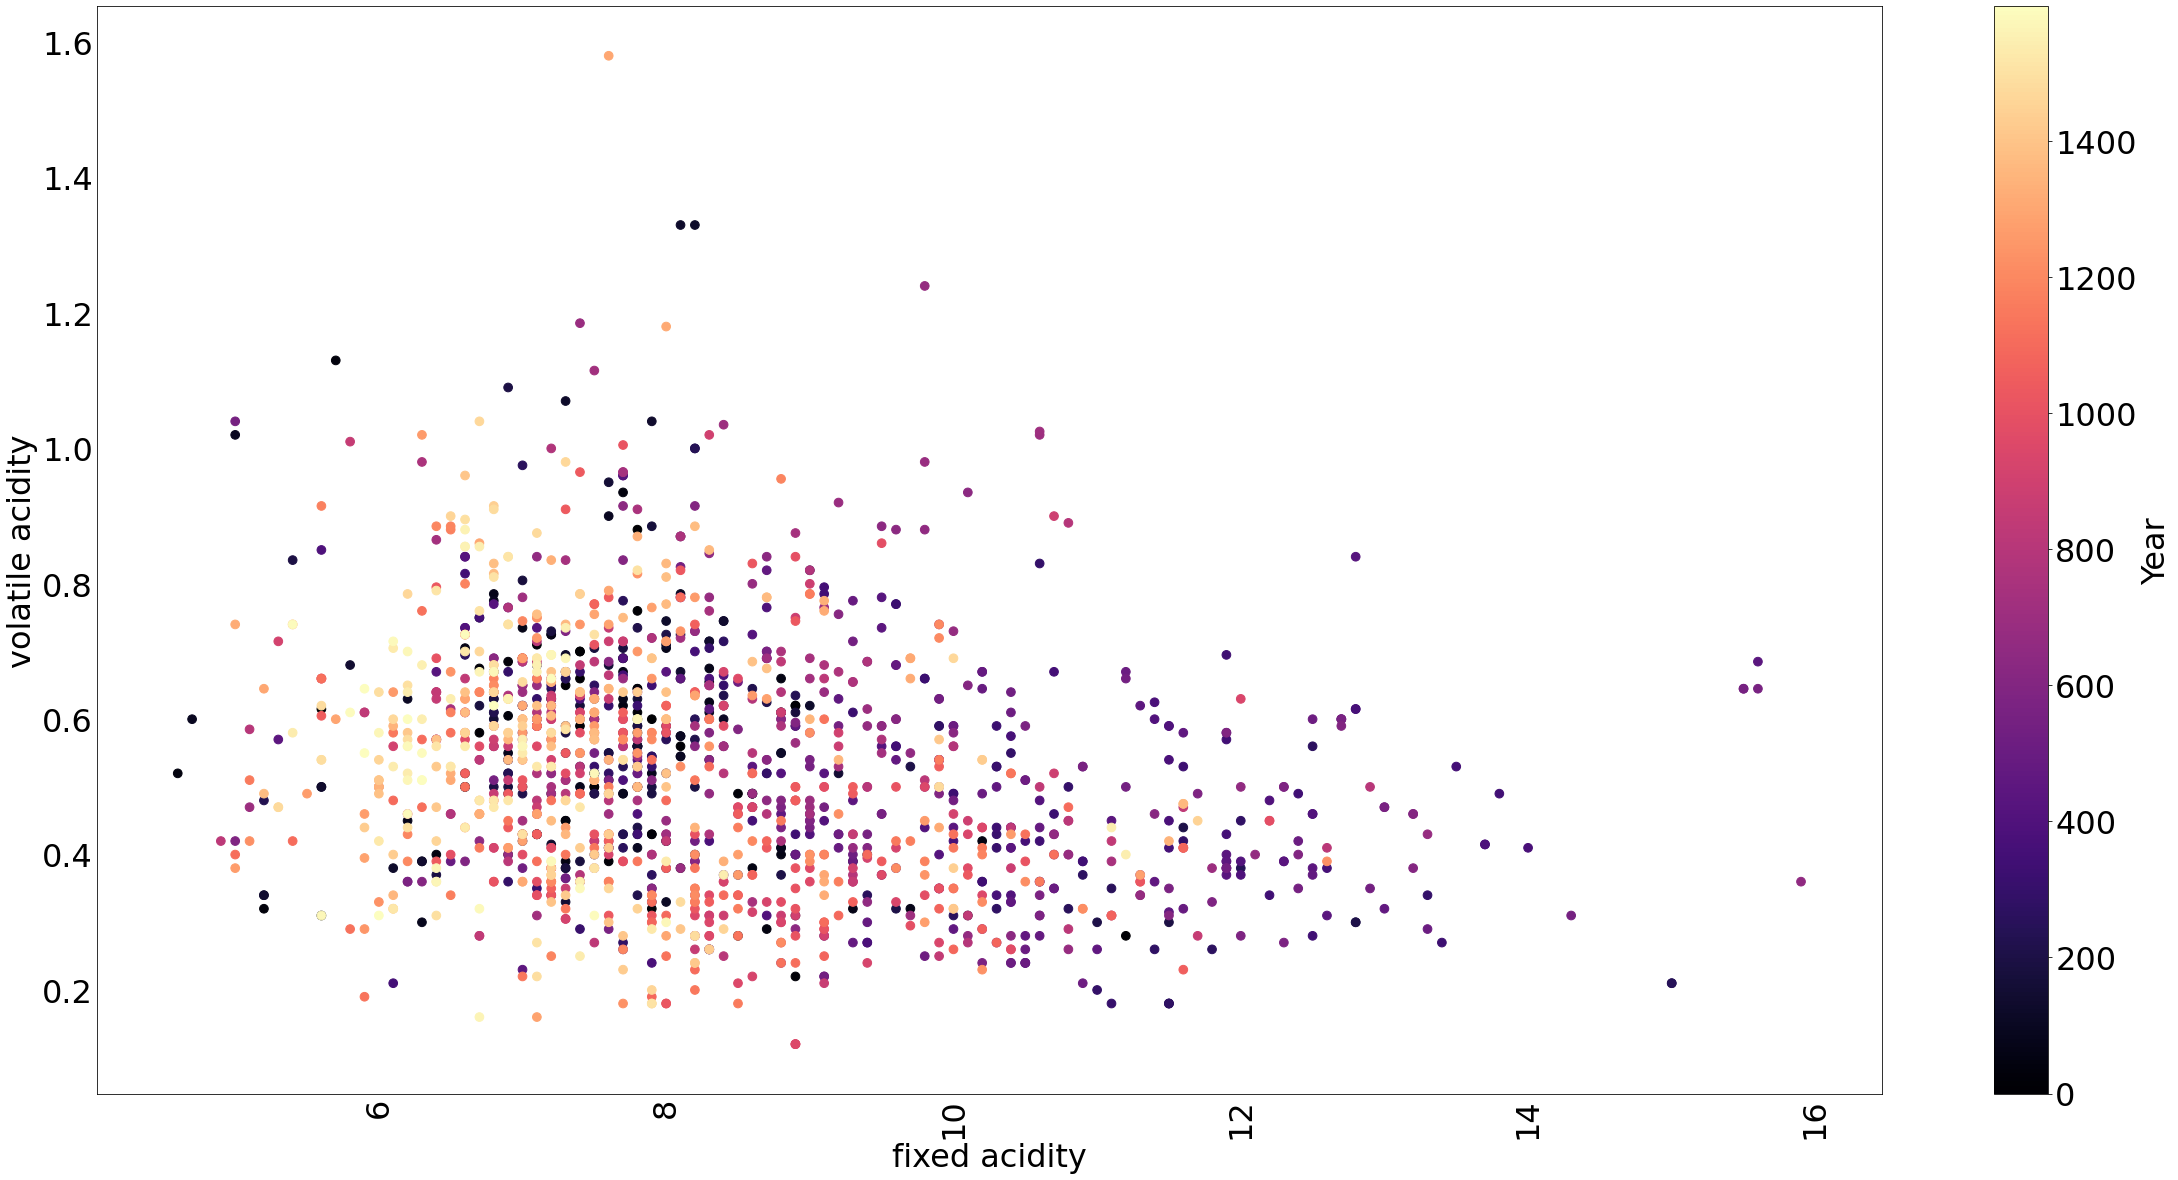

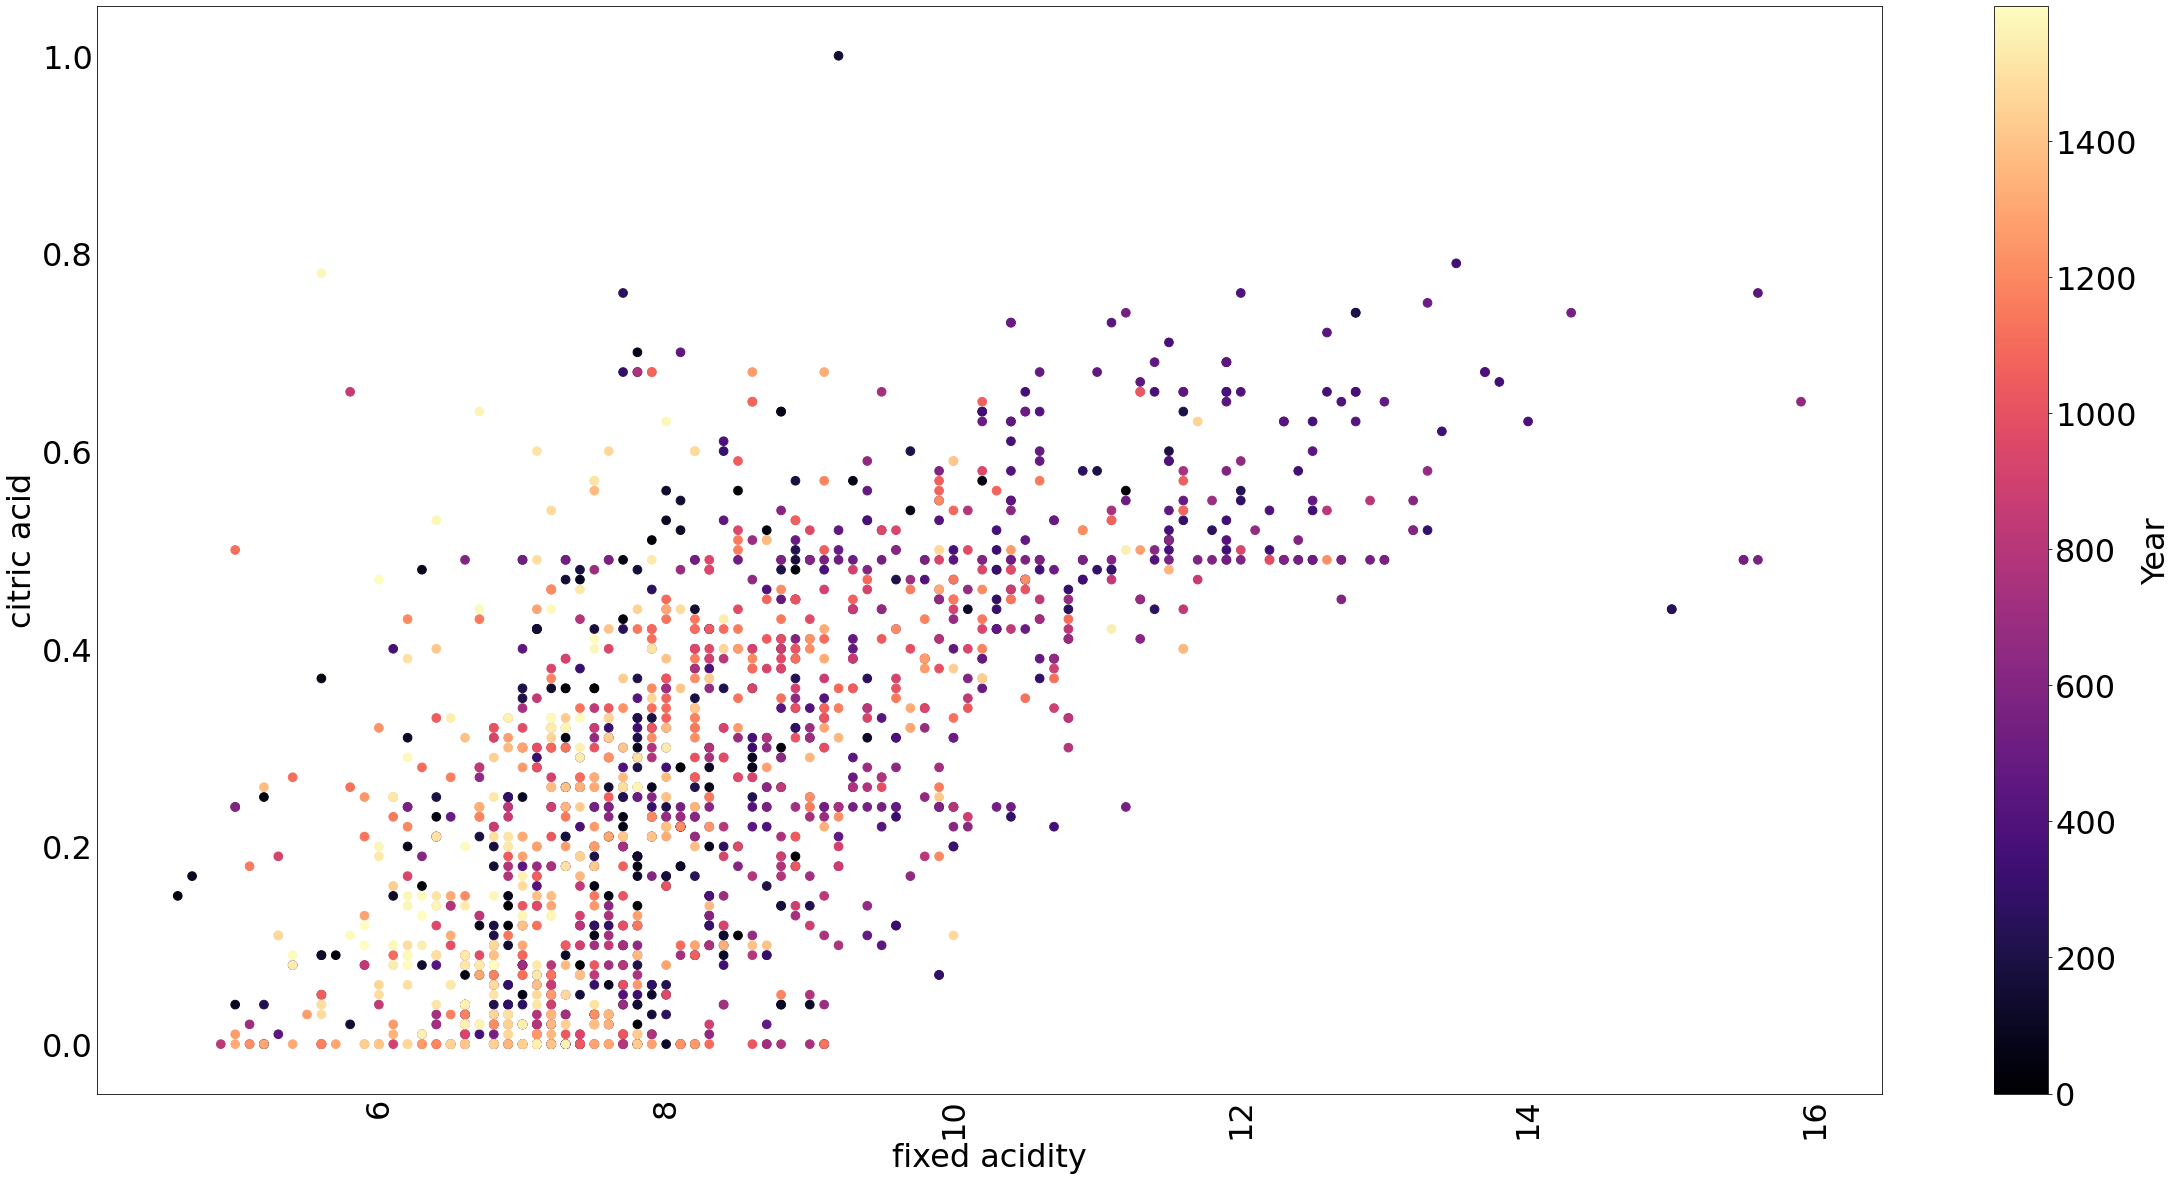

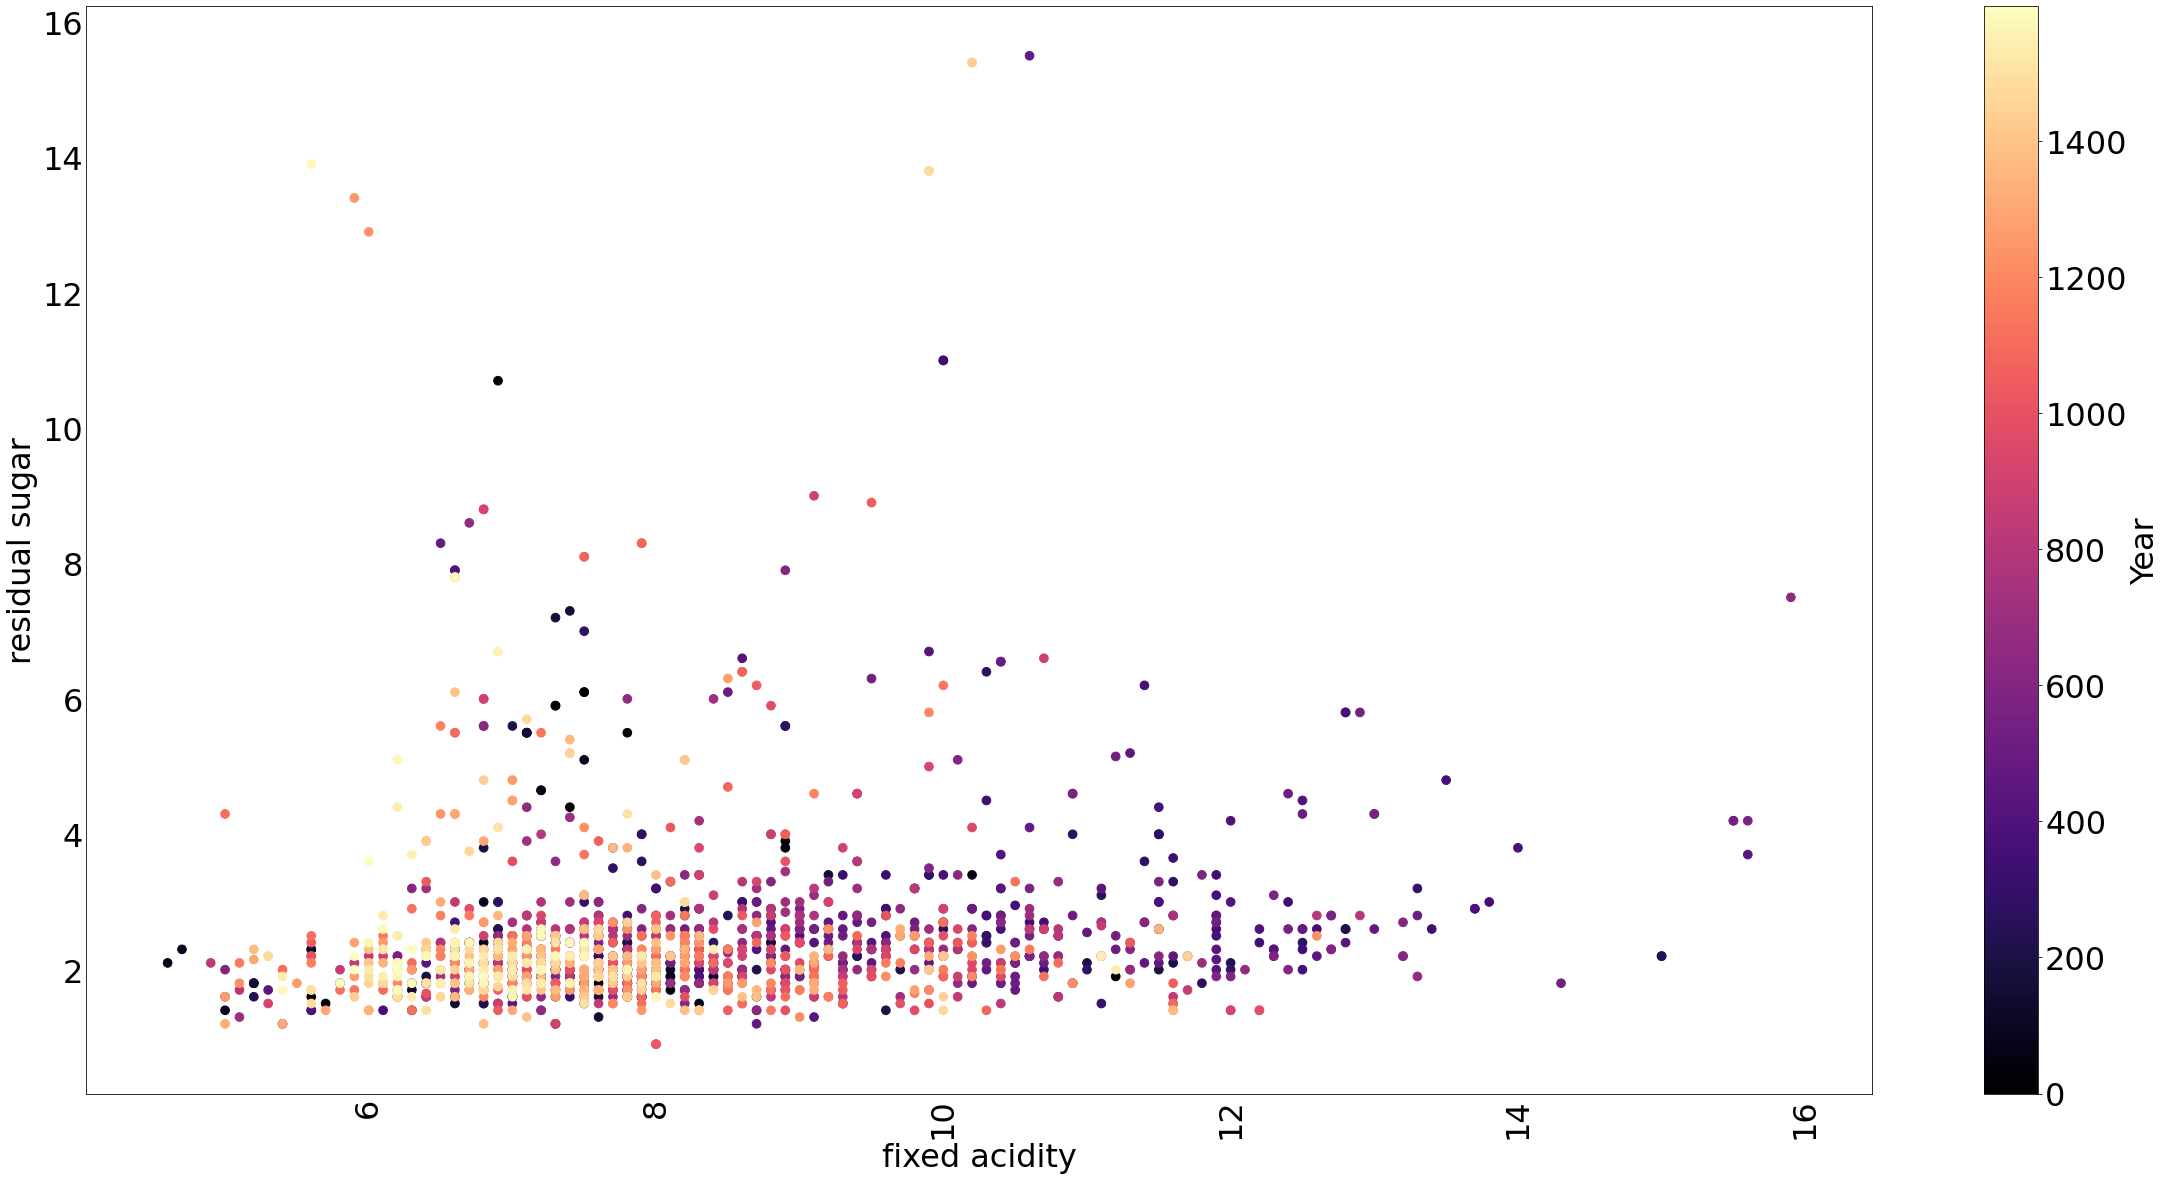

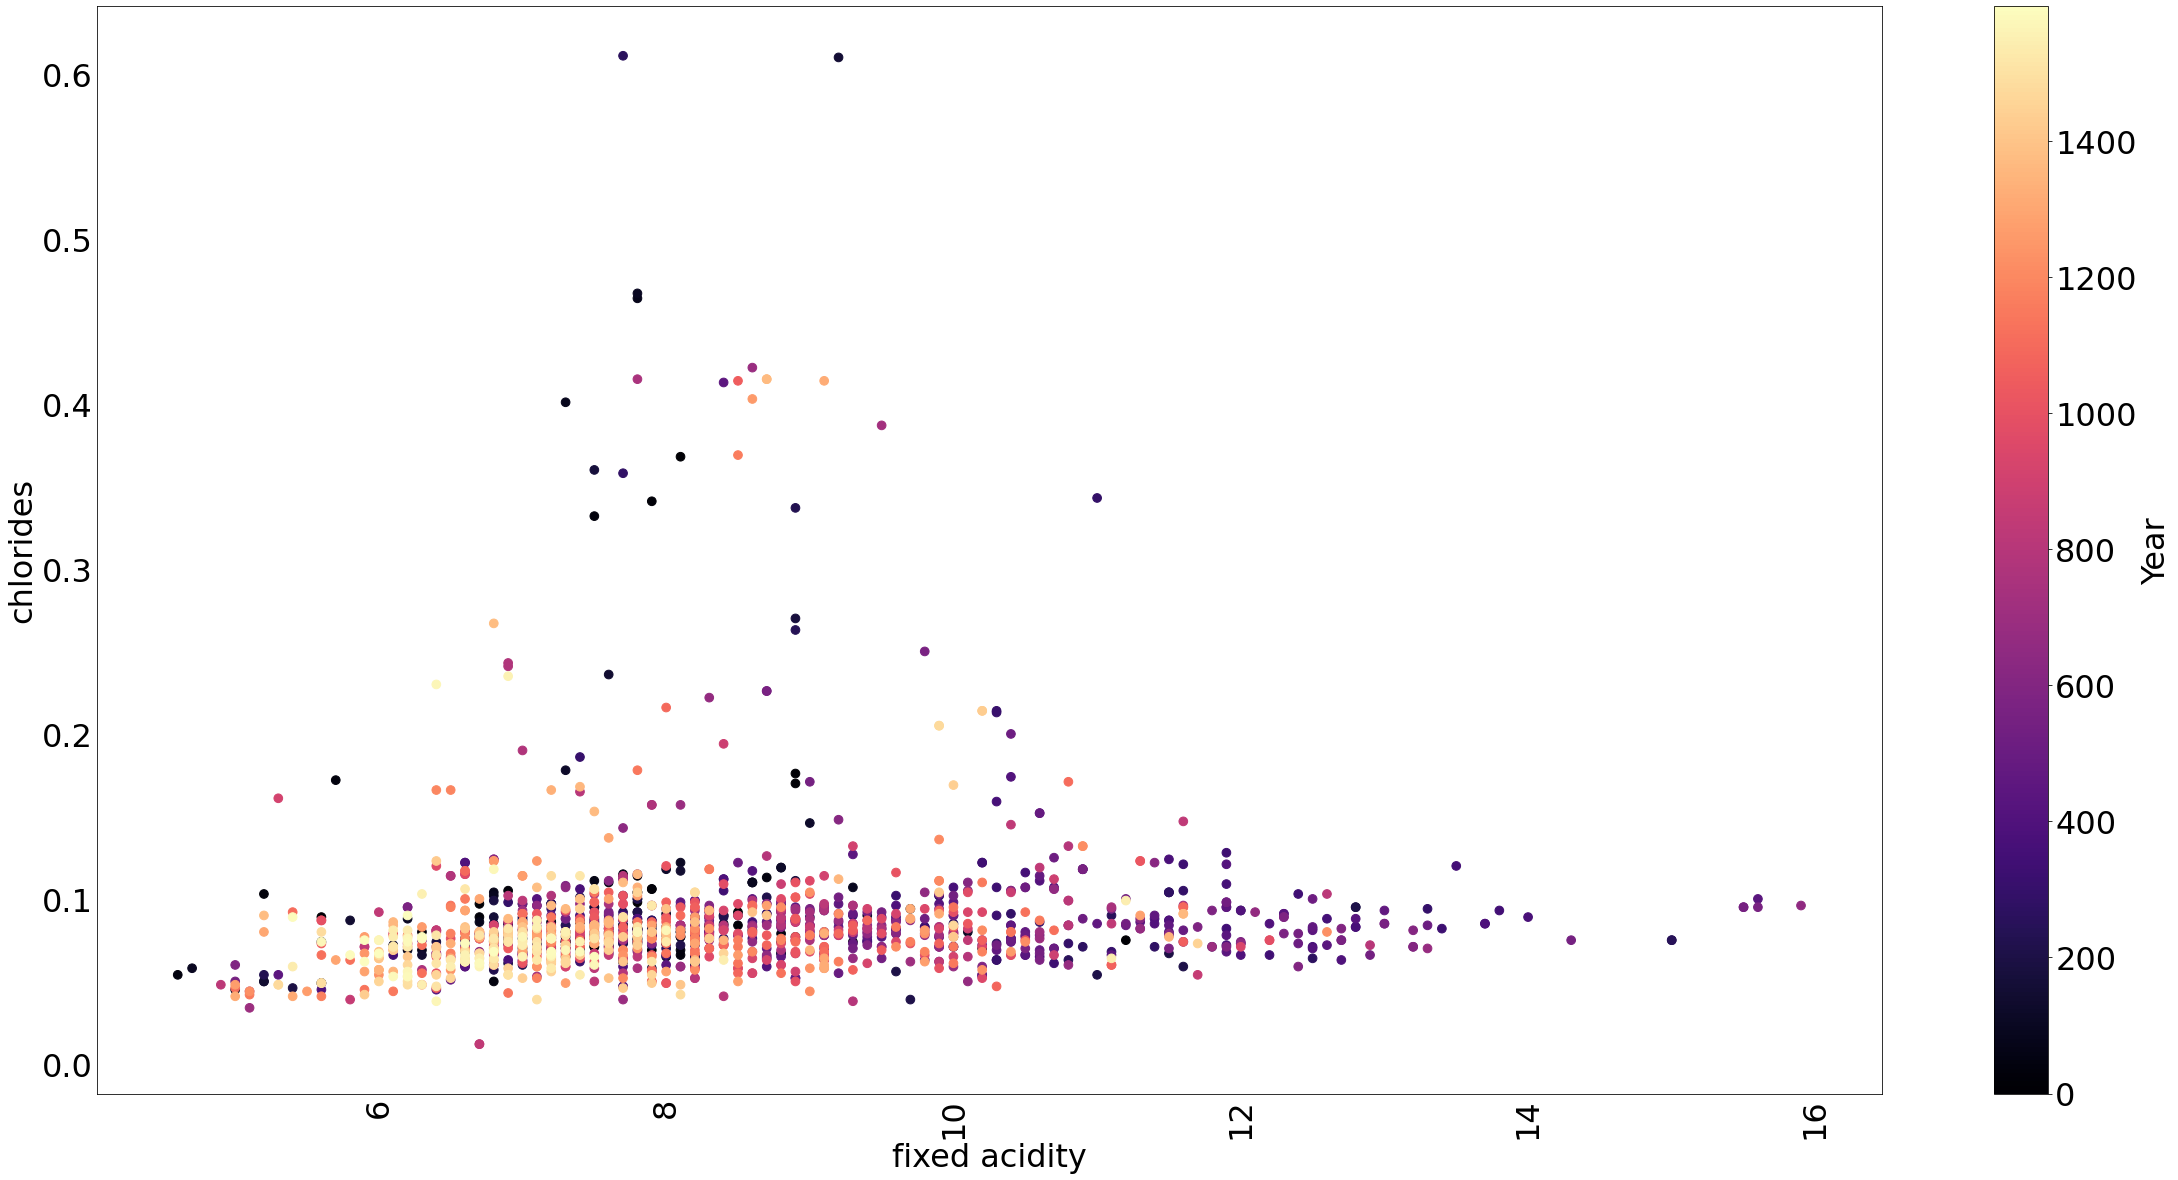

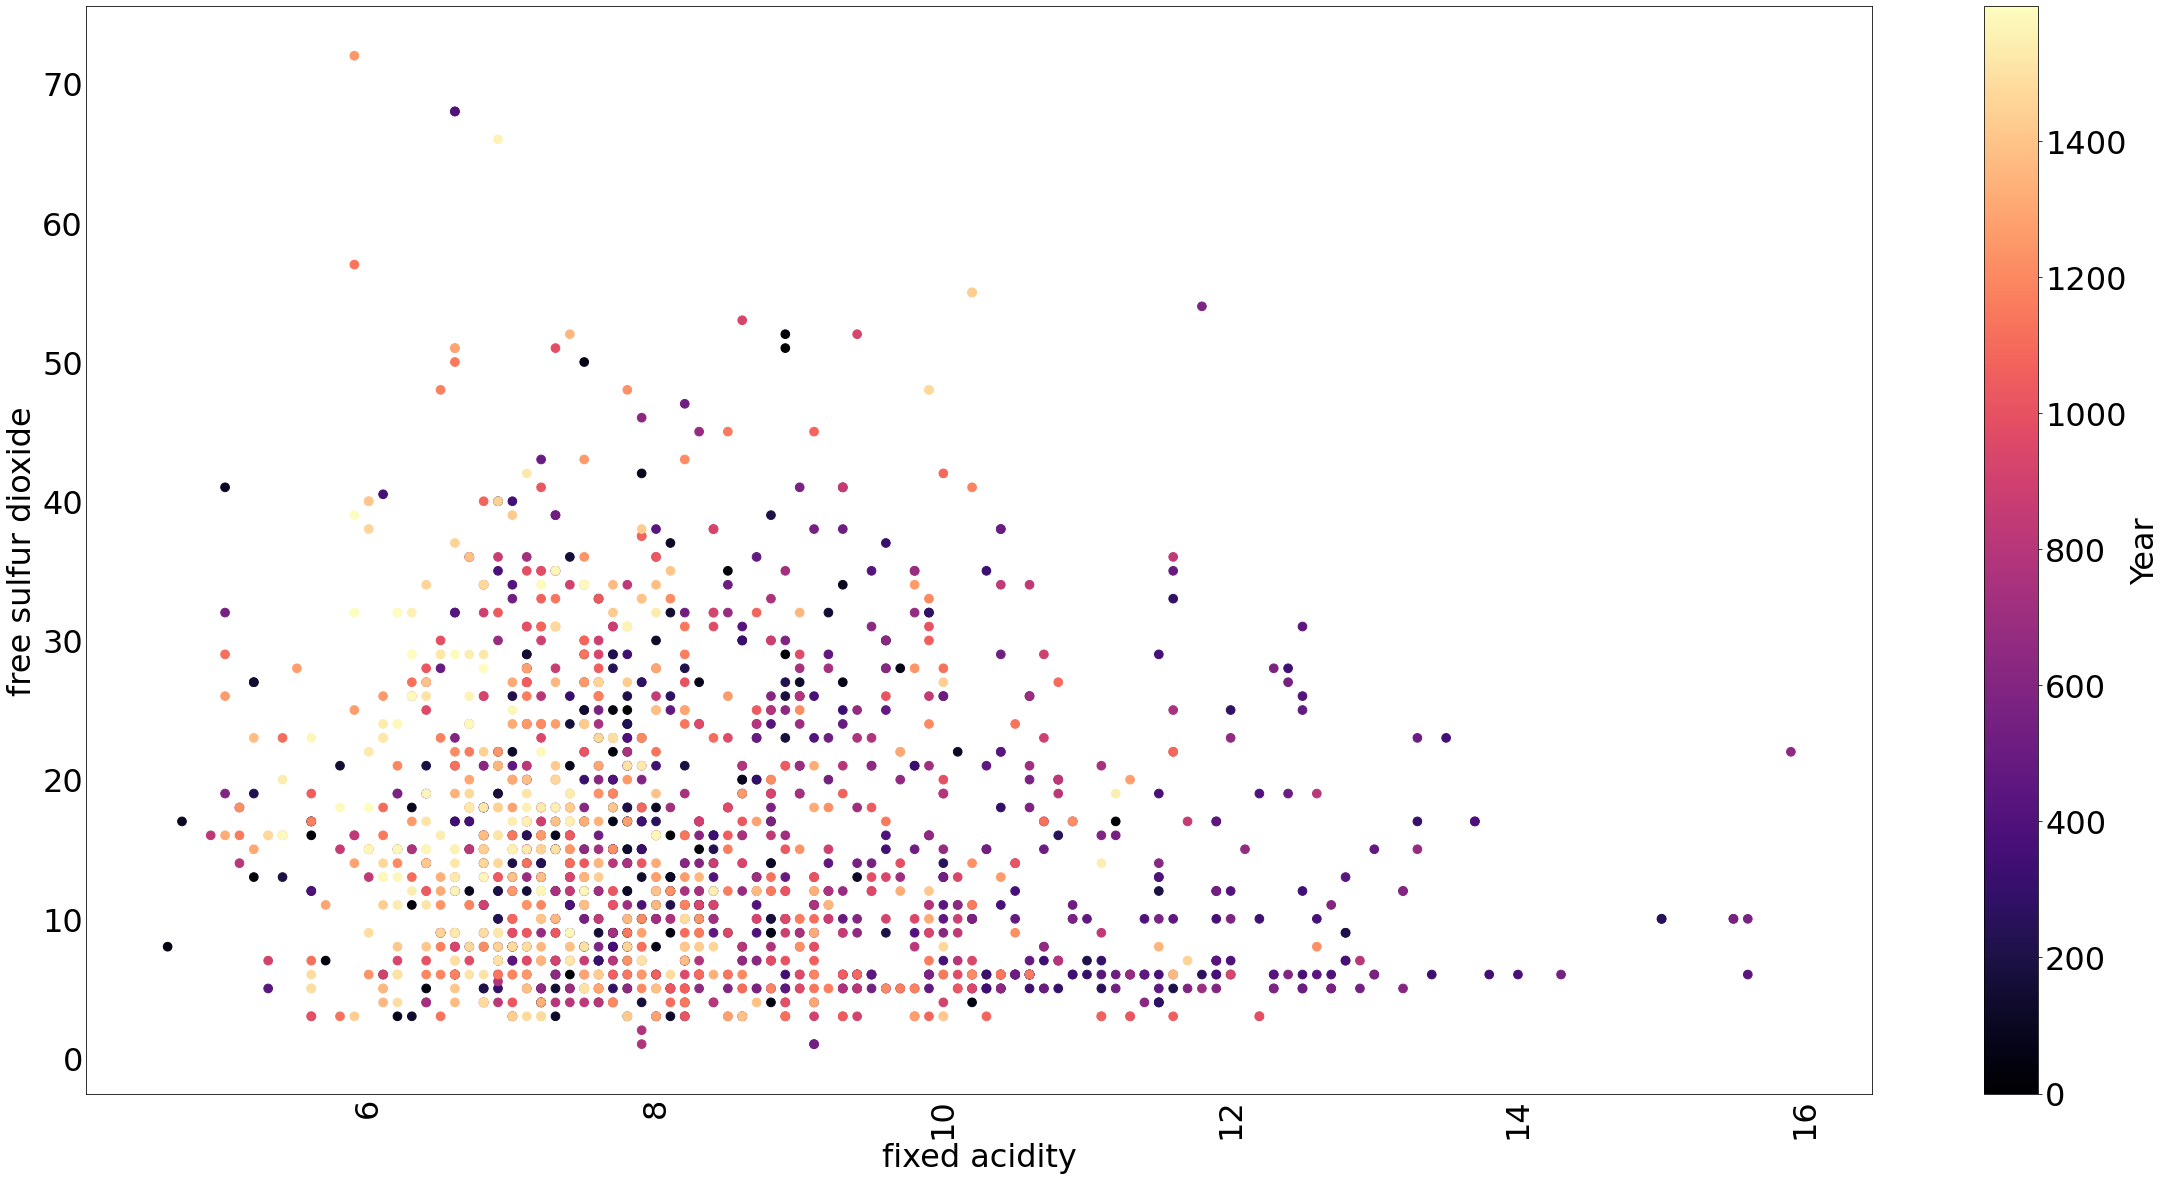

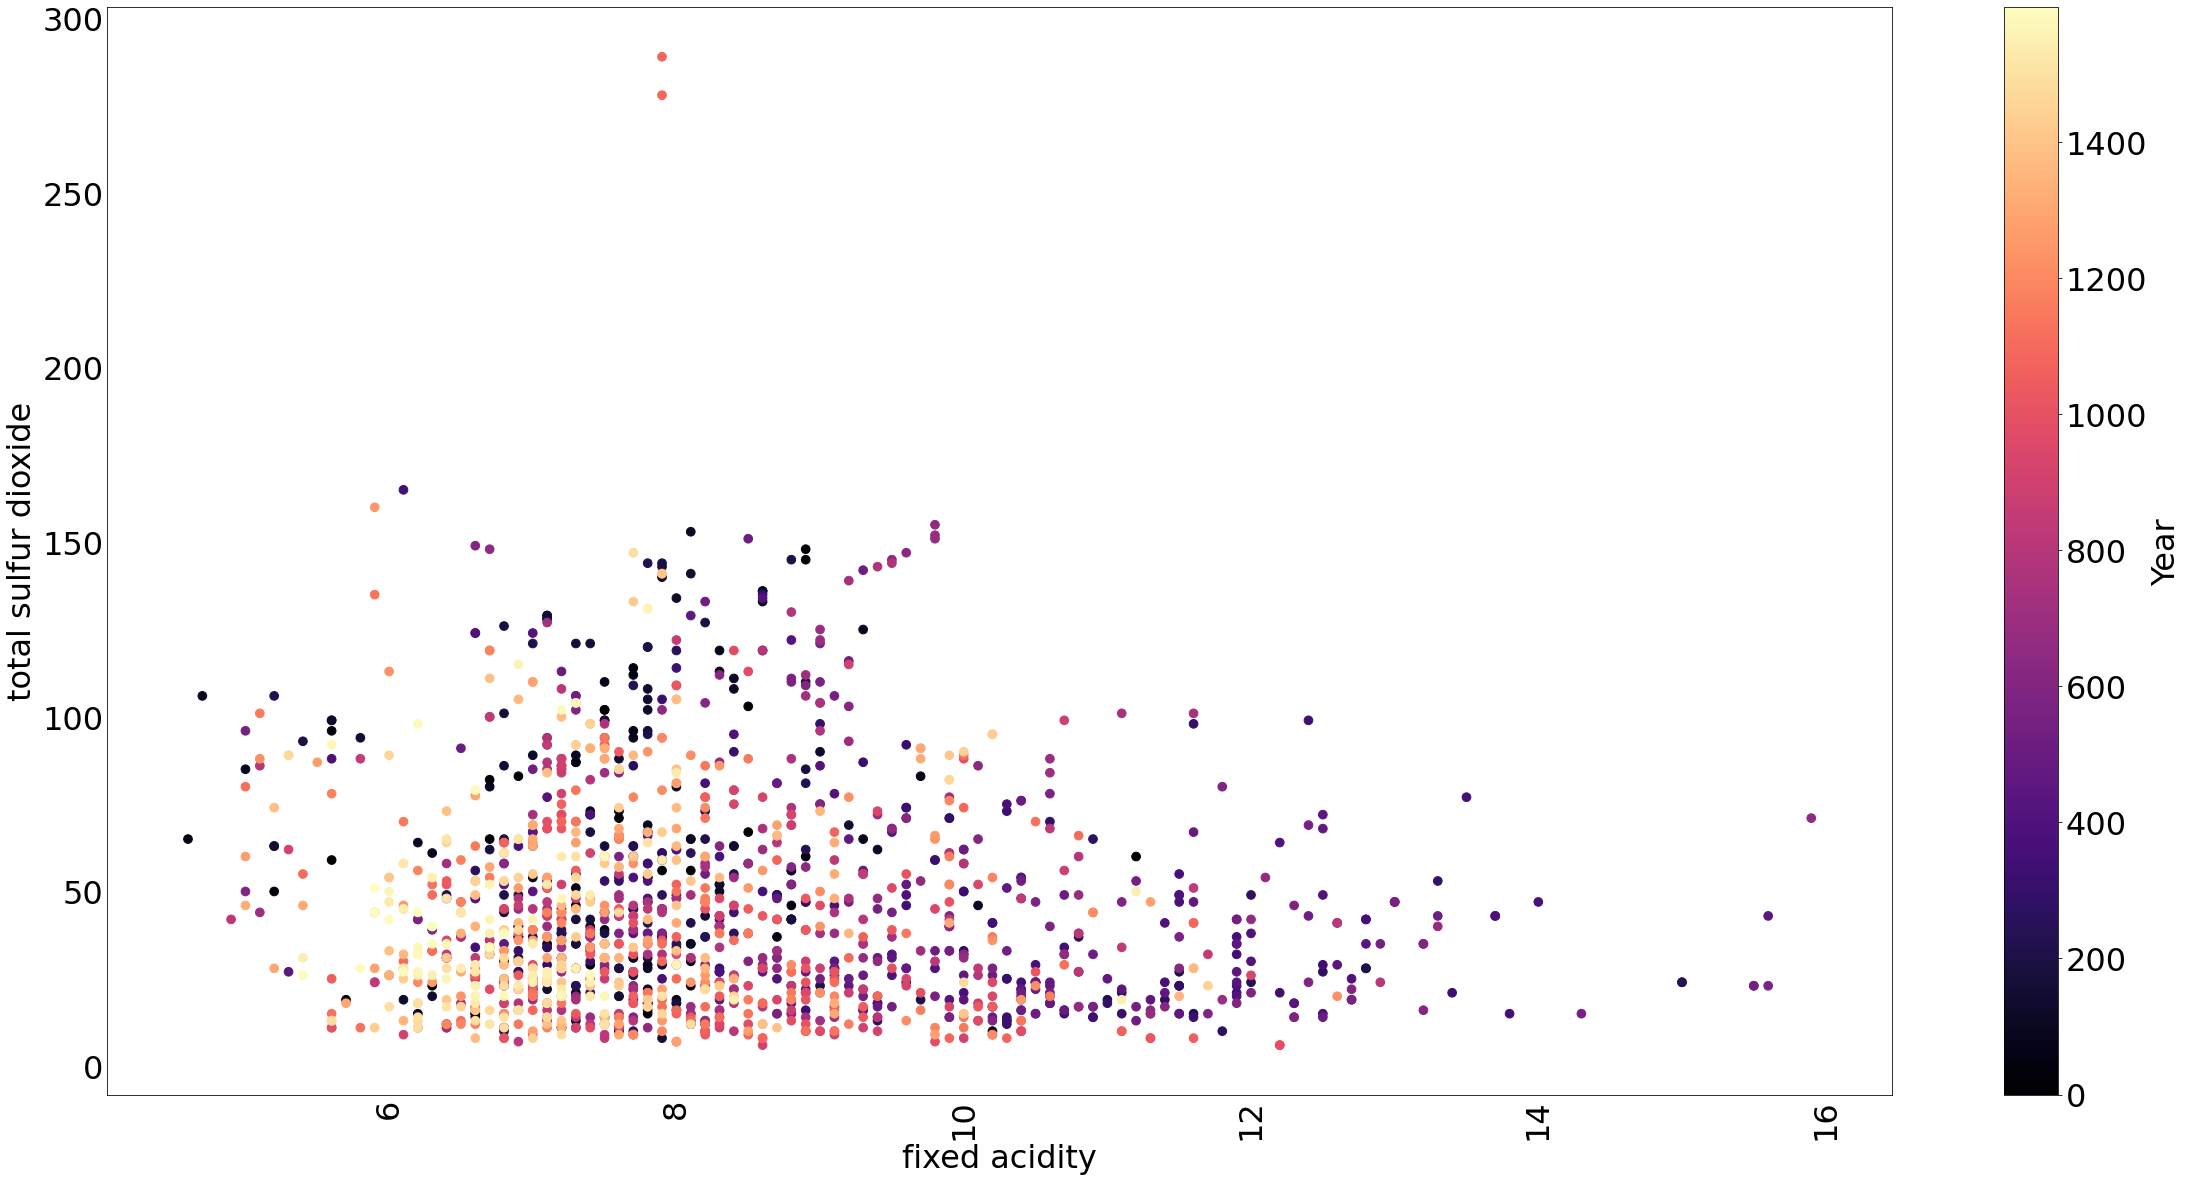

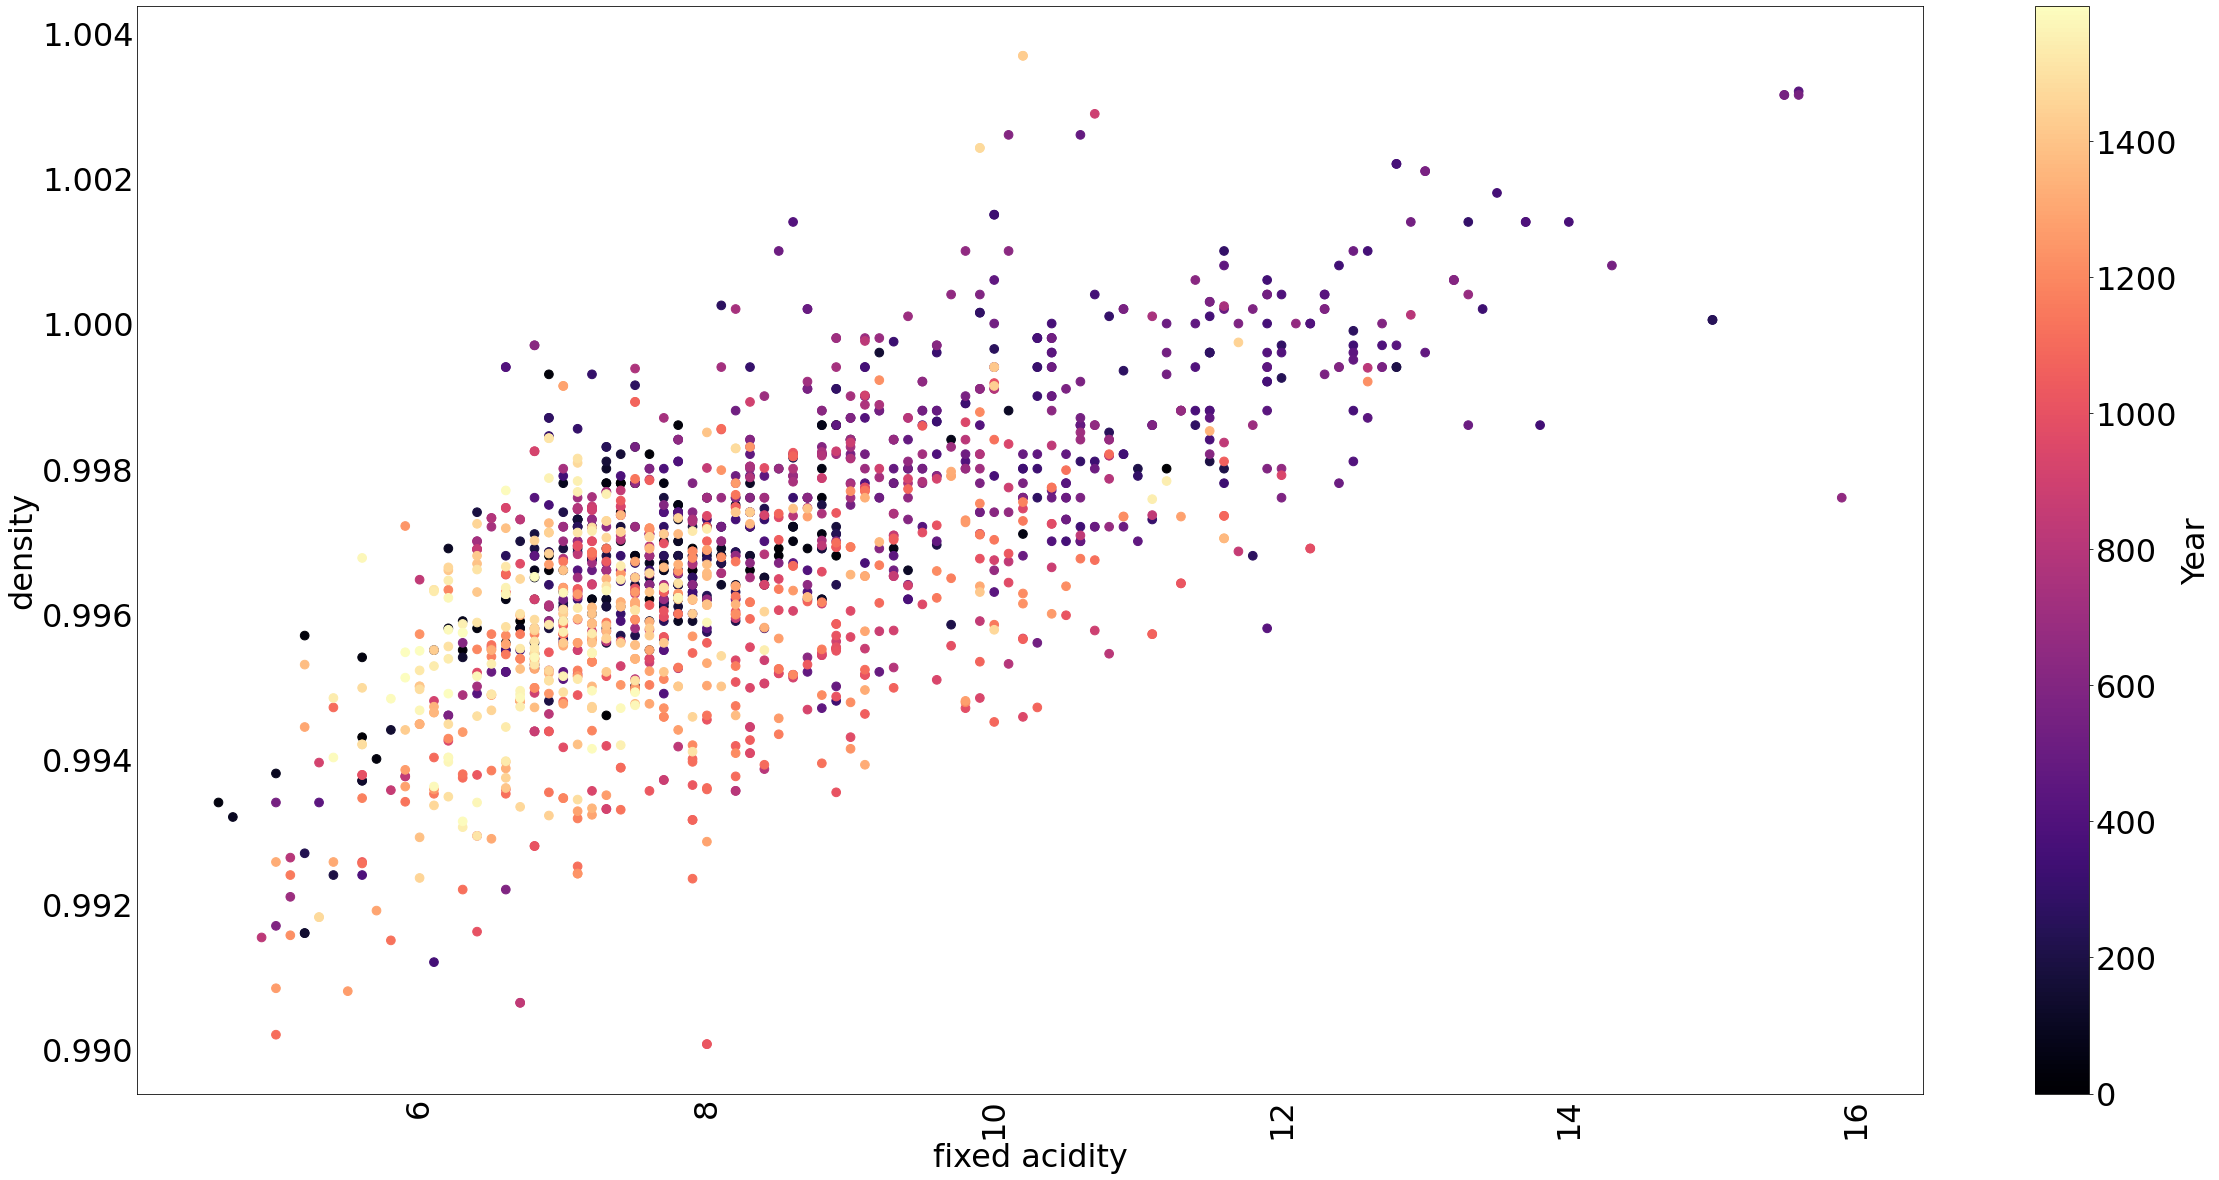

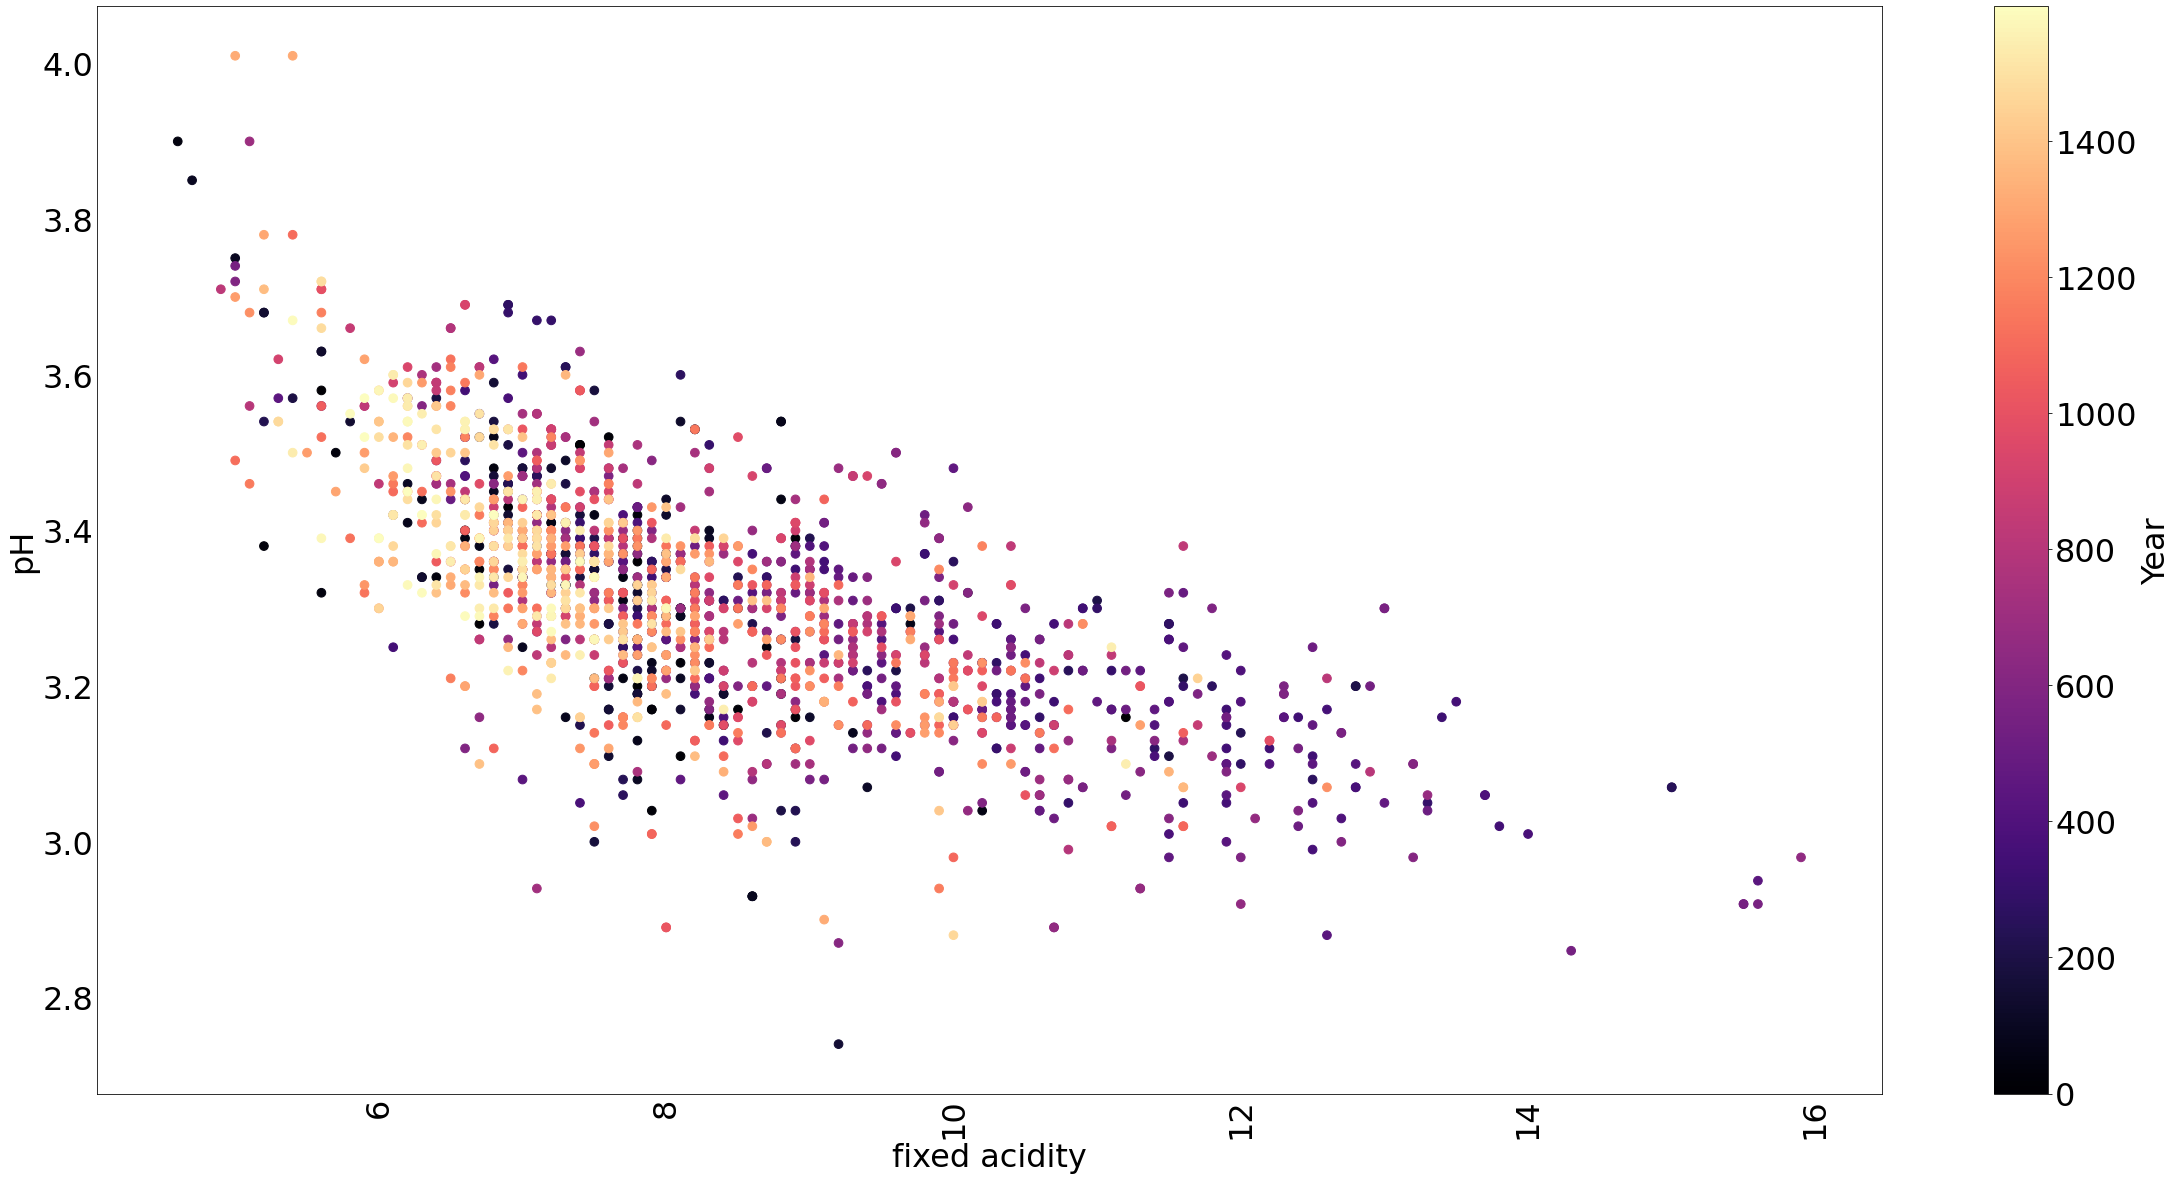

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_ts_scatter(df, s = 75, figsize = (40, 20), save_fig = False, pp = None):
    plot_vars = list(df.keys())
    for x in plot_vars:
        for y in plot_vars:
            if x != y:
                fig, ax = plt.subplots(figsize = figsize)
            
                if "Year" not in df.keys():
                    df["Year"] = [int(str(ind)[:4]) for ind in df.index]
                
                df.plot.scatter(x = x, y = y, s = s, ax = ax, c = "Year", cmap = "magma")
                
                ax.tick_params(axis = 'x', rotation =90)
                ax.tick_params('both', length = 0, which = 'both')
                
                if save_fig:
                    try:
                        os.mkdir("plots")
                    except:
                        pass
                
                    directory = "plots/" + x[:12] + " " + y[:12] + " c=Year"
                    plt.savefig(directory + ".png")
                    if pp != None: pp.savefig(fig, bbox_inches = "tight")
                        

plt.rcParams.update({"font.size":32})
plot_ts_scatter(data2)

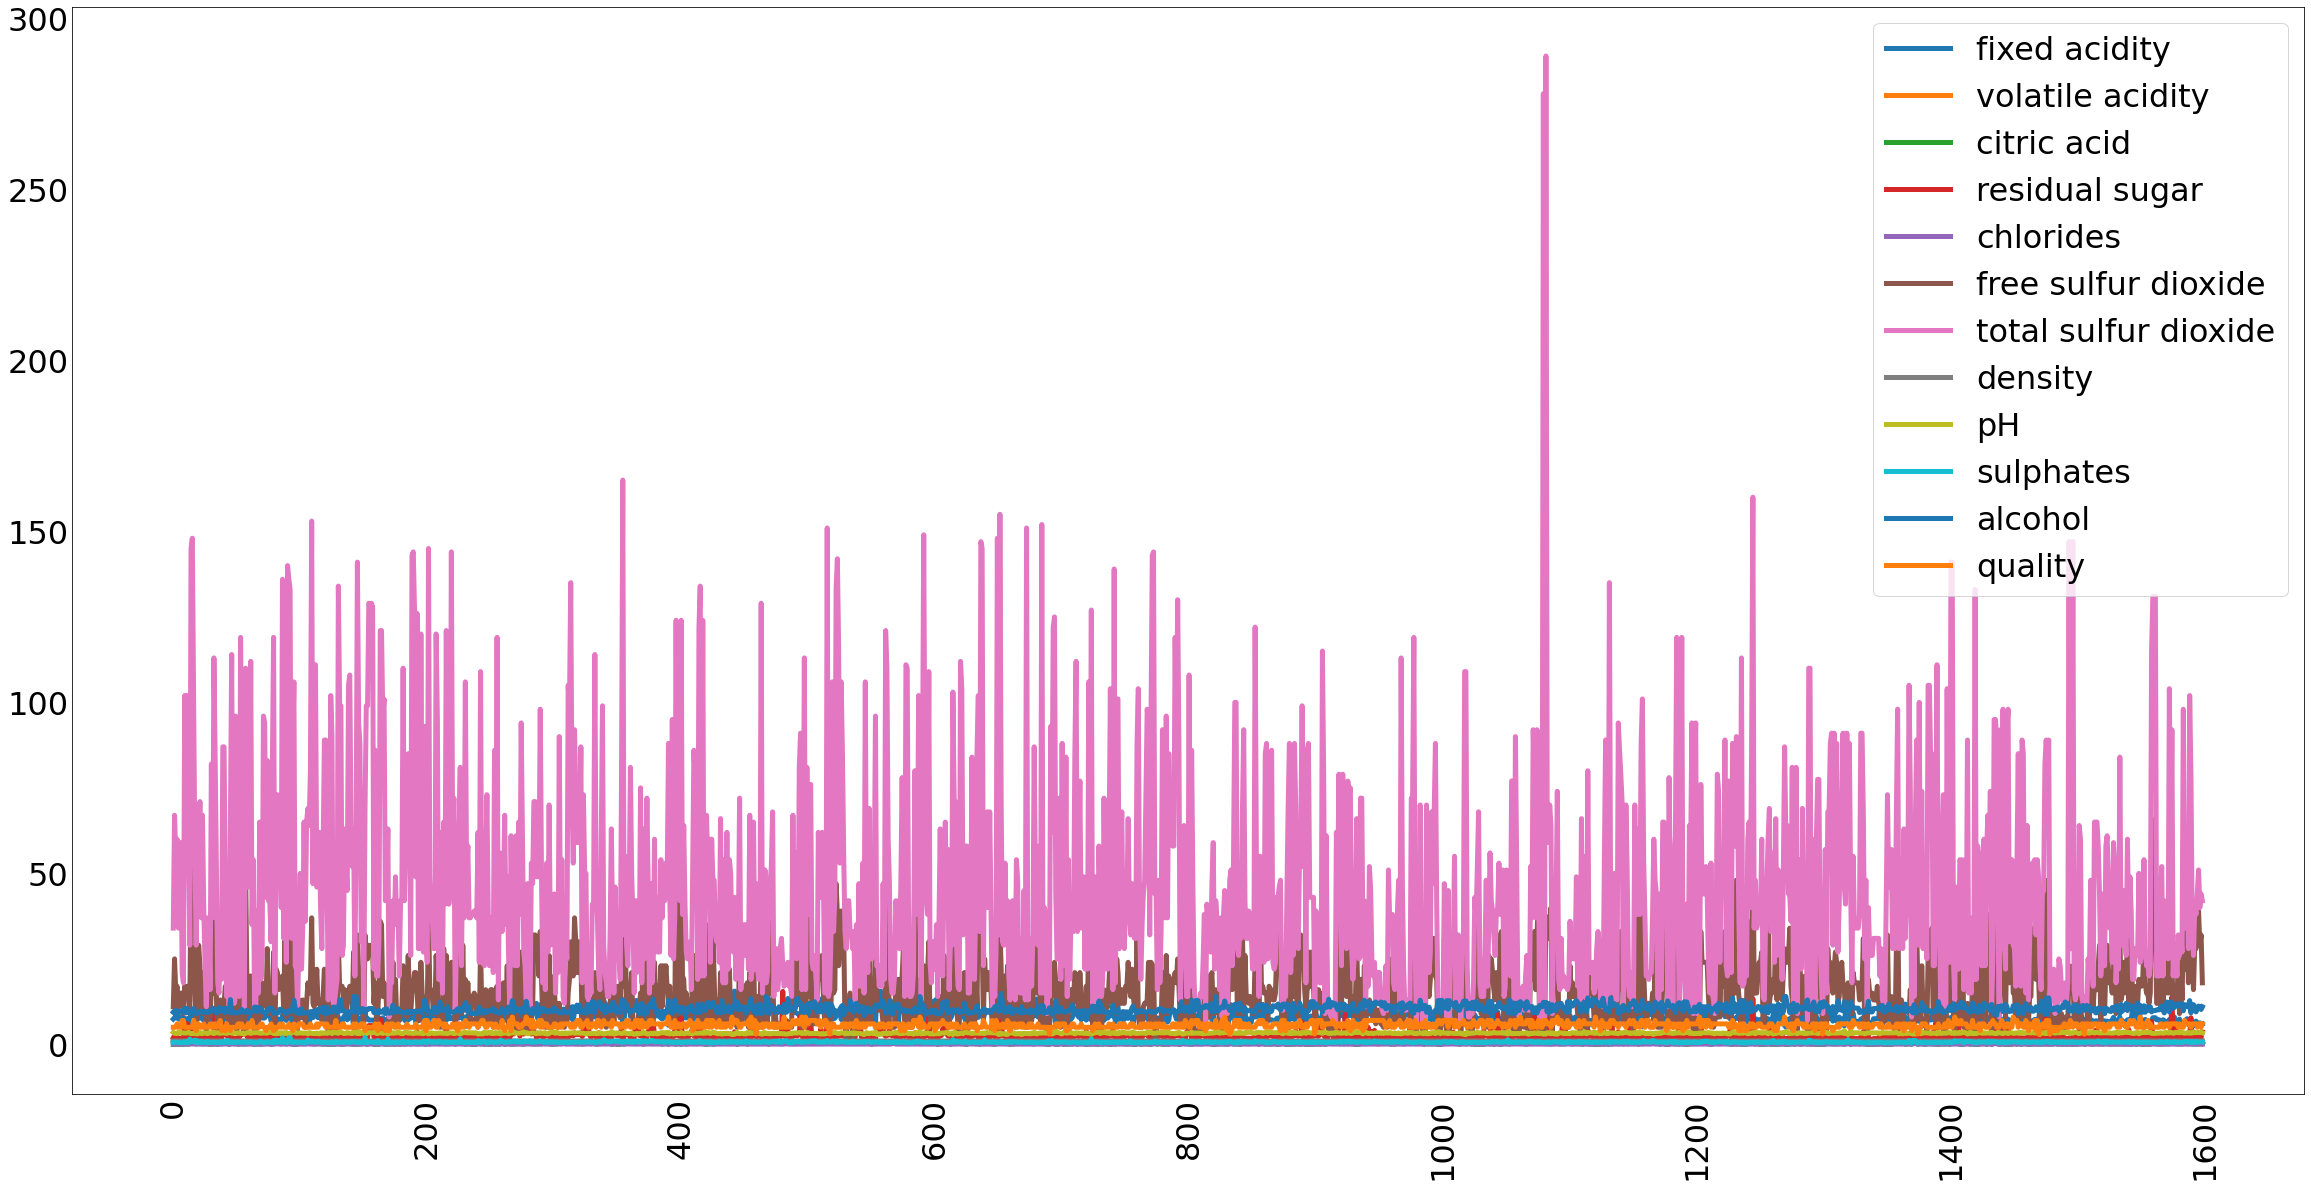

In [61]:
def plot_lines(df, linewidth = 1, figsize = (40,20), pp = None):
    
    fig, ax = plt.subplots(figsize = figsize)
    df.plot.line(linewidth = linewidth, ax = ax)
    ax.tick_params(axis = 'x', rotation = 90)
    ax.tick_params('both', length = 0, which = 'both')
    vals = ax.get_yticks()
    ax.set_yticklabels([int(x) for x in vals])
    
    remove_chars = "[]:$'\\"
    filename=str(list(df.keys()))
    for char in remove_chars:
        filename = filename.replace(char, "")
    plt.savefig(filename[:50]+ " line.png", bbox_inches = "tight")
    if pp != None:
        pp.savefig(fig, bbox_inches = "tight")

plt.rcParams.update({"font.size":32})
plot_lines(df = data2, linewidth = 5, figsize = (40, 20), pp = None)